# Sanity check: is self-consistent really consistent? Allow velocity dispersion into the system? Match the wavelength range with the MaNGA range?
`metallicity model recovery tests.ipynb` did a lot of tests looking into how well the models recovery parameters from mock spectra, if there are biases in the more complex models, etc. Some things require addressing:
1. For a lot of the fits, metallicity seems to be over-estimated even though in self-consistent setups. Could this be due to spectral binning issues? Try: include a velocity dispersion typical in galaxies (100 km/s) in the models created, and have it as a free parameter in fitting. This should soften the effect of binning issues
2. Can we 100% be sure self-consistent fits are actually self-consistent? Is there resampling of the SSP templates going on somewhere?
3. We should make this as close as MaNGA data as possible, so limit the fitted wavelength range to around that of when we are fitting MaNGA.

In [1]:
import bagpipes as pipes
# setting bagpipes R_spec to as high as possible for perfect generation of models
pipes.config.R_spec = 4340
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

import sys
sys.path.append('../../..')
from code_bits.fitting import *
from code_bits.add_psbtwin import *
from code_bits.add_ceh_funcs import *

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


In [2]:
# load in true SFH
model_ages_original, model_sfh = load_model_sfh('../../../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')

3623.3599 7799.9995


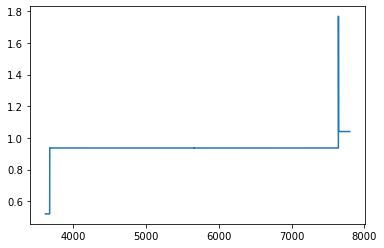

In [6]:
spectrum = np.loadtxt(fname='../../../Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_'+
                      "2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test"+".csv", 
                      delimiter=',', skiprows=1)
obs_wavs = spectrum[:,0][np.where((spectrum[:,0]>3623) & (spectrum[:,0]<7500*(1+0.04)))]
print(min(obs_wavs), max(obs_wavs))
plt.plot(obs_wavs[:-1], np.diff(obs_wavs))

### To avoid the severe bias to the `age` parameter in psb SFH comps (means the lookback time of beginning of star formation), I am shifting and compressing Yirui's model truth SFH closer to the observation time, making beginning of star formation to be closer to cosmic noon at z~2-3.

10.350524938318015 Gyr


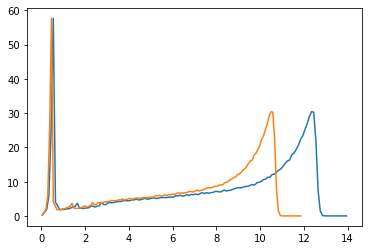

In [8]:
squishing_factor = 0.85
model_ages = model_ages_original*squishing_factor
plt.plot(model_ages_original, model_sfh)
plt.plot(model_ages, model_sfh)
print(cosmo.age(0.04) - cosmo.age(2.5))

[1.06817341e+01 3.23549458e+00 4.67499997e-01 2.29522818e+02
 5.34899465e+02 9.24162911e-02 1.09328153e+01]
[1.06870221e+01 1.63461055e+00 9.95242899e+04 4.67499980e-01
 2.26365783e+02 5.90580893e+02 8.71638738e-02 1.09474482e+01]


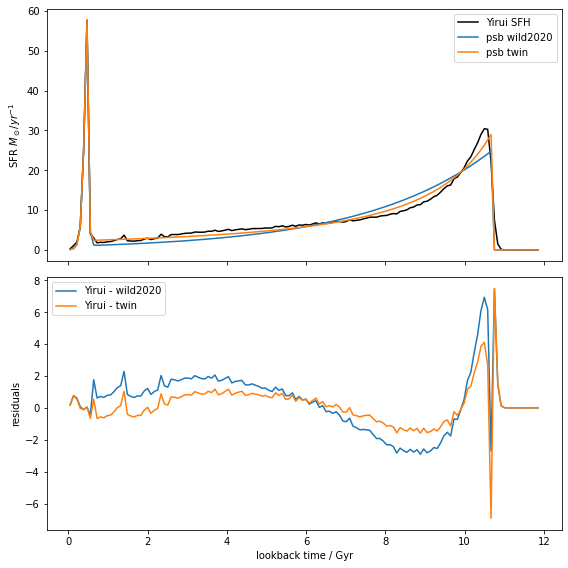

In [9]:
import scipy
# using scipy curve fit to get a fit to the true SFH
popt_wild2020,pcov = scipy.optimize.curve_fit(psb_wild2020, model_ages, model_sfh, 
                                     bounds=([10.5,0.5,0,100,100,0,10],[13,10,2,1000,1000,1,12]))
# best fits
print(popt_wild2020)

# using scipy curve fit to get a fit to the true SFH
popt_twin,pcov = scipy.optimize.curve_fit(psb_twin_, model_ages, model_sfh, 
                                     bounds=([10,0.01,1000,0,10,1,0,10],[13,1000,100000,2,1000,1000,1,12]))
# best fits
print(popt_twin)

fig,ax = plt.subplots(2,1, figsize=[8,8], sharex=True)

predict_sfh_wild2020 = psb_wild2020(model_ages, *popt_wild2020)
predict_sfh_twin = psb_twin_(model_ages, *popt_twin)
ax[0].plot(model_ages, model_sfh, label='Yirui SFH', color='k')
ax[0].plot(model_ages, predict_sfh_wild2020, label='psb wild2020')
ax[0].plot(model_ages, predict_sfh_twin, label='psb twin')
ax[0].set_ylabel('SFR $M_\odot / yr^{-1}$')
ax[0].legend()

ax[1].plot(model_ages, model_sfh-predict_sfh_wild2020, label='Yirui - wild2020')
ax[1].plot(model_ages, model_sfh-predict_sfh_twin, label='Yirui - twin')
ax[1].set_ylabel('residuals')
ax[1].set_xlabel('lookback time / Gyr')
ax[1].legend()
plt.tight_layout()
plt.show()

In [13]:
"""
cols = [m_SFH, m_CEH, m_zmet_old, m_zmet_burst, 
        m_zmet_slope, f_SFH, f_CEH, f_CEH_fixed, 
        f_nlive]
"""
fits_list = []
# delta
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'delta',
                 'm_zmet_old':1.0, 'm_veldisp':100,
                 'f_SFH':'psb_wild2020',
                 'f_CEH':'delta', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'delta',
                 'm_zmet_old':2.0, 'm_veldisp':100,
                 'f_SFH':'psb_wild2020',
                 'f_CEH':'delta', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'psb_twin', 'm_CEH':'delta',
                 'm_zmet_old':1.0, 'm_veldisp':100,
                 'f_SFH':'psb_twin',
                 'f_CEH':'delta', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'yirui', 'm_CEH':'delta',
                 'm_zmet_old':1.0, 'm_veldisp':100,
                 'f_SFH':'psb_wild2020',
                 'f_CEH':'delta', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'yirui', 'm_CEH':'delta',
                 'm_zmet_old':1.0, 'm_veldisp':100,
                 'f_SFH':'psb_twin',
                 'f_CEH':'delta', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'delta',
                 'm_zmet_old':1.0, 'm_veldisp':100,
                 'f_SFH':'psb_wild2020',
                 'f_CEH':'2step', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'delta',
                 'm_zmet_old':2.0, 'm_veldisp':100,
                 'f_SFH':'psb_wild2020',
                 'f_CEH':'2step', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'yirui', 'm_CEH':'delta',
                 'm_zmet_old':1.0, 'm_veldisp':100,
                 'f_SFH':'psb_wild2020',
                 'f_CEH':'2step', 'f_CEH_fixed':False,
                 'f_nlive':400})
# 2step
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'2step',
                 'm_zmet_old':1.0, 'm_zmet_burst':2.0,
                 'm_veldisp':100,
                 'f_SFH':'psb_wild2020', 'f_CEH':'2step', 
                 'f_CEH_fixed':False, 'f_nlive':400})
fits_list.append({'m_SFH':'yirui', 'm_CEH':'2step',
                 'm_zmet_old':1.0, 'm_zmet_burst':2.0,
                 'm_veldisp':100,
                 'f_SFH':'psb_wild2020', 'f_CEH':'2step', 
                 'f_CEH_fixed':False, 'f_nlive':400})
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'2step',
                 'm_zmet_old':2.0, 'm_zmet_burst':1.0,
                 'm_veldisp':100,
                 'f_SFH':'psb_wild2020', 'f_CEH':'2step', 
                 'f_CEH_fixed':False, 'f_nlive':400})
# slope+2step
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'delta',
                 'm_zmet_old':1.0, 'm_veldisp':100, 
                 'f_SFH':'psb_wild2020',
                 'f_CEH':'slope+2step', 'f_CEH_fixed':False,
                 'f_nlive':400})
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'slope+2step',
                 'm_zmet_old':'auto', 'm_zmet_burst':2.0,
                 'm_zmet_slope':-0.1, 'm_veldisp':100, 'm_dust':None, 
                 'f_SFH':'psb_wild2020',
                 'f_CEH':'slope+2step', 'f_CEH_fixed':False,
                 'f_nlive':400, 'f_dust':None, 'f_GPnoise':False,
                 'binby':1})


fit_table = pd.DataFrame(fits_list)[
    ['m_SFH', 'm_CEH', 'm_zmet_old', 'm_zmet_burst', 'm_zmet_slope', 'm_dust', 'm_veldisp',
     'f_SFH', 'f_CEH', 'f_CEH_fixed', 'f_dust', 'f_GPnoise',
     'f_nlive', 'binby']
]

fit_table['m_dust'] = fit_table['m_dust'].where(fit_table['m_dust'].notnull(), None)
fit_table['f_dust'] = fit_table['f_dust'].where(fit_table['f_dust'].notnull(), None)
fit_table['f_GPnoise'] = fit_table['f_GPnoise'].where(fit_table['f_GPnoise'].notnull(), False)
fit_table['binby'] = fit_table['binby'].where(fit_table['binby'].notnull(), 1)

fit_table

m_SFH        m_CEH m_zmet_old  m_zmet_burst  m_zmet_slope m_dust  \
0   psb_wild2020        delta          1           NaN           NaN   None   
1   psb_wild2020        delta          2           NaN           NaN   None   
2       psb_twin        delta          1           NaN           NaN   None   
3          yirui        delta          1           NaN           NaN   None   
4          yirui        delta          1           NaN           NaN   None   
5   psb_wild2020        delta          1           NaN           NaN   None   
6   psb_wild2020        delta          2           NaN           NaN   None   
7          yirui        delta          1           NaN           NaN   None   
8   psb_wild2020        2step          1           2.0           NaN   None   
9          yirui        2step          1           2.0           NaN   None   
10  psb_wild2020        2step          2           1.0           NaN   None   
11  psb_wild2020        delta          1           NaN           NaN   None   
12  psb_wild2020  slope+2step       auto           2.0          -0.1   None   

    m_veldisp         f_SFH        f_CEH  f_CEH_fixed f_dust f_GPnoise  \
0         100  psb_wild2020        delta        False   None     False   
1         100  psb_wild2020        delta        False   None     False   
2         100      psb_twin        delta        False   None     False   
3         100  psb_wild2020        delta        False   None     False   
4         100      psb_twin        delta        False   None     False   
5         100  psb_wild2020        2step        False   None     False   
6         100  psb_wild2020        2step        False   None     False   
7         100  psb_wild2020        2step        False   None     False   
8         100  psb_wild2020        2step        False   None     False   
9         100  psb_wild2020        2step        False   None     False   
10        100  psb_wild2020        2step        False   None     False   
11        100  psb_wild2020  slope+2step        False   None     False   
12        100  psb_wild2020  slope+2step        False   None     False   

    f_nlive  binby  
0       400    1.0  
1       400    1.0  
2       400    1.0  
3       400    1.0  
4       400    1.0  
5       400    1.0  
6       400    1.0  
7       400    1.0  
8       400    1.0  
9       400    1.0  
10      400    1.0  
11      400    1.0  
12      400    1.0

In [14]:
def genIDs(fit_settings):
    # galID = {m_SFH}_{m_CEH}{delta's metallicity}
    if fit_settings['m_SFH'] == 'yirui':
        m_SFH = fit_settings['m_SFH']
    elif fit_settings['m_SFH'] == 'psb_wild2020':
        m_SFH = 'psb2'
    elif fit_settings['m_SFH'] == 'psb_twin':
        m_SFH = 'psbtwin'
        
    if fit_settings['m_CEH'] == 'delta':
        m_CEH = 'uniform'+str(int(fit_settings['m_zmet_old']))+'Zsun'
    elif fit_settings['m_CEH'] == '2step':
        m_CEH = f'2step{int(fit_settings["m_zmet_old"])}to{int(fit_settings["m_zmet_burst"])}Zsun'
    else: m_CEH = fit_settings['m_CEH']
        
    if fit_settings['m_dust'] is not None:
        m_dust = '_'+fit_settings['m_dust']
    else: m_dust = ''
        
    veldisp = fit_settings['m_veldisp']
    
    galID = f'{m_SFH}_{m_CEH}{m_dust}_veldisp{veldisp}'
    
    # runID = {f_SFH}_{f_CEH}_{fixed or not}_{nlive}
    if fit_settings['f_SFH'] == 'psb_wild2020':
        f_SFH = 'psb2'
    elif fit_settings['f_SFH'] == 'psb_twin':
        f_SFH = 'psbtwin'
    
    f_CEH = fit_settings['f_CEH']
    
    if fit_settings['f_CEH_fixed']:
        f_CEH_fixed = '_fixed'
    else: f_CEH_fixed = ''
    
    if fit_settings['f_dust'] is not None:
        f_dust = '_'+fit_settings['f_dust']
    else: f_dust = ''
        
    if fit_settings['f_GPnoise']:
        f_GPnoise = '_GPon'
    else: f_GPnoise = ''
    
    runID = f"{f_SFH}_{f_CEH}{f_CEH_fixed}{f_dust}{f_GPnoise}_nlive{str(fit_settings['f_nlive'])}"+ \
        f"_bin_by_{int(fit_settings['binby'])}_4340_Rspec_veldispOn"
    
    return galID, runID

fit_table['galID'] = ''
fit_table['runID'] = ''
for i,row in fit_table.iterrows():
    galID, runID = genIDs(row)
    print(galID, runID)
    fit_table.loc[i,'galID'] = galID
    fit_table.loc[i,'runID'] = runID
# old_fit = True means that it is recycling a previously-done fit for another test that also fit the
# requirements, but used the non-altered version of Yirui's true SFH. This means the results will not be
# directly comparable but conclusions should still be possible to be drawn
fit_table['old_fit'] = [False]*len(fit_table.index)
                        
fit_table

psb2_uniform1Zsun_veldisp100 psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn
psb2_uniform2Zsun_veldisp100 psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn
psbtwin_uniform1Zsun_veldisp100 psbtwin_delta_nlive400_bin_by_1_4340_Rspec_veldispOn
yirui_uniform1Zsun_veldisp100 psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn
yirui_uniform1Zsun_veldisp100 psbtwin_delta_nlive400_bin_by_1_4340_Rspec_veldispOn
psb2_uniform1Zsun_veldisp100 psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn
psb2_uniform2Zsun_veldisp100 psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn
yirui_uniform1Zsun_veldisp100 psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn
psb2_2step1to2Zsun_veldisp100 psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn
yirui_2step1to2Zsun_veldisp100 psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn
psb2_2step2to1Zsun_veldisp100 psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn
psb2_uniform1Zsun_veldisp100 psb2_slope+2step_nlive400_bin_by_1_4340_Rspec_veldispOn
psb2_slope+2step_veldisp100 ps

m_SFH        m_CEH m_zmet_old  m_zmet_burst  m_zmet_slope m_dust  \
0   psb_wild2020        delta          1           NaN           NaN   None   
1   psb_wild2020        delta          2           NaN           NaN   None   
2       psb_twin        delta          1           NaN           NaN   None   
3          yirui        delta          1           NaN           NaN   None   
4          yirui        delta          1           NaN           NaN   None   
5   psb_wild2020        delta          1           NaN           NaN   None   
6   psb_wild2020        delta          2           NaN           NaN   None   
7          yirui        delta          1           NaN           NaN   None   
8   psb_wild2020        2step          1           2.0           NaN   None   
9          yirui        2step          1           2.0           NaN   None   
10  psb_wild2020        2step          2           1.0           NaN   None   
11  psb_wild2020        delta          1           NaN           NaN   None   
12  psb_wild2020  slope+2step       auto           2.0          -0.1   None   

    m_veldisp         f_SFH        f_CEH  f_CEH_fixed f_dust f_GPnoise  \
0         100  psb_wild2020        delta        False   None     False   
1         100  psb_wild2020        delta        False   None     False   
2         100      psb_twin        delta        False   None     False   
3         100  psb_wild2020        delta        False   None     False   
4         100      psb_twin        delta        False   None     False   
5         100  psb_wild2020        2step        False   None     False   
6         100  psb_wild2020        2step        False   None     False   
7         100  psb_wild2020        2step        False   None     False   
8         100  psb_wild2020        2step        False   None     False   
9         100  psb_wild2020        2step        False   None     False   
10        100  psb_wild2020        2step        False   None     False   
11        100  psb_wild2020  slope+2step        False   None     False   
12        100  psb_wild2020  slope+2step        False   None     False   

    f_nlive  binby                            galID  \
0       400    1.0     psb2_uniform1Zsun_veldisp100   
1       400    1.0     psb2_uniform2Zsun_veldisp100   
2       400    1.0  psbtwin_uniform1Zsun_veldisp100   
3       400    1.0    yirui_uniform1Zsun_veldisp100   
4       400    1.0    yirui_uniform1Zsun_veldisp100   
5       400    1.0     psb2_uniform1Zsun_veldisp100   
6       400    1.0     psb2_uniform2Zsun_veldisp100   
7       400    1.0    yirui_uniform1Zsun_veldisp100   
8       400    1.0    psb2_2step1to2Zsun_veldisp100   
9       400    1.0   yirui_2step1to2Zsun_veldisp100   
10      400    1.0    psb2_2step2to1Zsun_veldisp100   
11      400    1.0     psb2_uniform1Zsun_veldisp100   
12      400    1.0      psb2_slope+2step_veldisp100   

                                                runID  old_fit  
0   psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn    False  
1   psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn    False  
2   psbtwin_delta_nlive400_bin_by_1_4340_Rspec_vel...    False  
3   psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn    False  
4   psbtwin_delta_nlive400_bin_by_1_4340_Rspec_vel...    False  
5   psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn    False  
6   psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn    False  
7   psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn    False  
8   psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn    False  
9   psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn    False  
10  psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn    False  
11  psb2_slope+2step_nlive400_bin_by_1_4340_Rspec_...    False  
12  psb2_slope+2step_nlive400_bin_by_1_4340_Rspec_...    False

In [15]:
def gen_model(fit_settings, vb=False, old_fit_params=None):
    model_components = {}
    model_components['redshift'] = 0.04
    
    psb = {}
    if fit_settings['m_SFH'] == 'psb_wild2020':
        #age, tau, burstage, alpha, beta, fburst, Mstar
        psb['massformed'] = popt_wild2020[-1]
        psb['age'] = popt_wild2020[0]
        psb['tau'] = popt_wild2020[1]
        psb['burstage'] = popt_wild2020[2]
        psb['alpha'] = popt_wild2020[3]
        psb['beta'] = popt_wild2020[4]
        psb['fburst'] = popt_wild2020[5]
        
    elif fit_settings['m_SFH'] == 'psb_twin':
        #age, alpha1, beta1, burstage, alpha2, beta2, fburst, Mstar
        #using custom input old_fit_params popt to generate a non-squeezed version of model SFH
        if old_fit_params is None:
            psb_twin_popt = popt_twin
        else:
            psb_twin_popt = old_fit_params
        psb['massformed'] = psb_twin_popt[-1]
        psb['age'] = psb_twin_popt[0]
        psb['alpha1'] = psb_twin_popt[1]
        psb['beta1'] = psb_twin_popt[2]
        psb['burstage'] = psb_twin_popt[3]
        psb['alpha2'] = psb_twin_popt[4]
        psb['beta2'] = psb_twin_popt[5]
        psb['fburst'] = psb_twin_popt[6]
        
    elif fit_settings['m_SFH'] == 'yirui':
        psb["massformed"] = 11.027233041278691
        psb["history"] = np.vstack([model_ages*10**9, model_sfh]).T
        
    if fit_settings['m_CEH'] == 'delta':
        psb['metallicity_type'] = 'delta'
        psb['metallicity'] = fit_settings['m_zmet_old']
        
    elif fit_settings['m_CEH'] == '2step':
        if fit_settings['m_SFH'] == 'yirui':
            psb['metallicity_type'] = 'two_step'
            psb['metallicity_step_age'] = popt_wild2020[2]
        else:
            psb['metallicity_type'] = 'psb_two_step'
        psb['metallicity_old'] = fit_settings['m_zmet_old']
        psb['metallicity_burst'] = fit_settings['m_zmet_burst']
        psb["metallicity_scatter"] = "delta"
        
    elif fit_settings['m_CEH'] == 'slope+2step':
        psb['metallicity_type'] = 'psb_linear_step'
        psb['metallicity_burst'] = fit_settings['m_zmet_burst']
        psb['metallicity_slope'] = fit_settings['m_zmet_slope']
        if fit_settings['m_zmet_old'] == 'auto':
            psb['metallicity_zero'] = cosmo.age(0.04).value*abs(psb['metallicity_slope'])
        else: psb['metallicity_zero'] = fit_settings['m_zmet_old']
        psb["metallicity_scatter"] = "delta"
    
    if fit_settings['m_SFH'] == 'yirui':
        model_components['custom'] = psb
    else:
        model_components[fit_settings['m_SFH']] = psb
        
    if fit_settings['m_dust'] == 'CF00':
        dust = {}
        dust['type'] = 'CF00'
        dust['Av'] = 1.0
        dust['eta'] = 3.0
        dust['n'] = 0.7
        model_components['dust'] = dust
        
    if fit_settings['m_veldisp'] is not None:
        model_components['veldisp'] = fit_settings['m_veldisp']

    psb_model = pipes.model_galaxy(model_components, spec_wavs=obs_wavs)
    
    if vb:
        psb_model.sfh.plot()
        psb_model.plot()
        from matplotlib.colors import LogNorm
        plt.imshow(psb_model.sfh.ceh.grid, norm=LogNorm())
        plt.show()
    
    return psb_model

def get_fit_instructions(fit_settings, z=0.04):
    """ Set up the desired fit_instructions dictionary. """
    
    psb = {}
    if fit_settings['f_SFH'] == 'psb_wild2020':
        psb["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr.
        psb["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
        psb["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
        psb["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
        psb["alpha"] = (0.01,1000)               # decline of burst
        psb["alpha_prior"] = "log_10"
        psb["beta"] = 500.                    # rise of burst: fixed
        psb["fburst"] = (0,1)
        
    elif fit_settings['f_SFH'] == 'psb_twin':
        psb["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr.
        psb["alpha1"] = (0.01, 5)
        psb["alpha1_prior"] = "log_10"
        psb["beta1"] = 7.52360609e+04
        psb["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
        psb["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
        psb["alpha2"] = (0.01,1000)               # decline of burst
        psb["alpha2_prior"] = "log_10"
        psb["beta2"] = 500.                    # rise of burst: fixed
        psb["fburst"] = (0,1)
        
    if fit_settings['f_CEH'] == 'delta':
        psb['metallicity_type'] = 'delta'
        if fit_settings['f_CEH_fixed']:
            psb["metallicity"] = fit_settings['m_zmet_old']
        else:
            psb["metallicity"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
            psb["metallicity_prior"] = "log_10"
    
    elif fit_settings['f_CEH'] == '2step':
        psb['metallicity_type'] = 'psb_two_step'
        psb["metallicity_scatter"] = "delta"
        if fit_settings['f_CEH_fixed']:
            psb["metallicity_old"] = fit_settings['m_zmet_old']
            psb["metallicity_burst"] = fit_settings['m_zmet_burst']
        else:
            psb["metallicity_old"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
            psb["metallicity_old_prior"] = "log_10"
            psb["metallicity_burst"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
            psb["metallicity_burst_prior"] = "log_10"
            psb["metallicity_scatter"] = "delta"
            
    elif fit_settings['f_CEH'] == 'slope+2step':
        psb['metallicity_type'] = 'psb_linear_step'
        psb["metallicity_scatter"] = "delta"
        if fit_settings['f_CEH_fixed']:
            psb["metallicity_burst"] = fit_settings['m_zmet_burst']
            psb["metallicity_slope"] = fit_settings['m_zmet_slope']
            if fit_settings['m_zmet_old'] == 'auto':
                psb["metallicity_zero"] = cosmo.age(0.04).value*abs(psb["metallicity_slope"])
            else: psb["metallicity_zero"] = fit_settings['m_zmet_old']
        else:
            psb["metallicity_burst"] = (0.01, 2.5)
            psb["metallicity_burst_prior"] = "log_10"
            psb["metallicity_slope"] = (-0.5, 0.5)
            psb["metallicity_zero"] = (-0.5, 3.0)
    
    fit_instructions = {}
    fit_instructions[fit_settings['f_SFH']] = psb
    fit_instructions['redshift'] = (z-0.02*z, z+0.02*z)
    
    if fit_settings['f_dust'] == 'CF00':
        dust = {}
        dust["type"] = "CF00"
        dust["eta"] = (1.0, 5.0)
        dust["Av"] = (0., 2.0)
        dust["n"] = 0.7
        fit_instructions['dust'] = dust
        
    if fit_settings['f_GPnoise']:
        noise = {}
        noise["type"] = "GP_exp_squared"
        noise["scaling"] = (0.1, 10.)
        noise["scaling_prior"] = "log_10"
        noise["norm"] = (0.01, 1.)
        noise["norm_prior"] = "log_10"
        noise["length"] = (0.01, 1.)
        noise["length_prior"] = "log_10"
        fit_instructions['noise'] = noise
        
    if fit_settings['binby'] > 1 or fit_settings['m_veldisp'] is not None:
        fit_instructions["veldisp"] = (0.1, 4000.)
        fit_instructions["veldisp_prior"] = "log_10"
    
    return fit_instructions

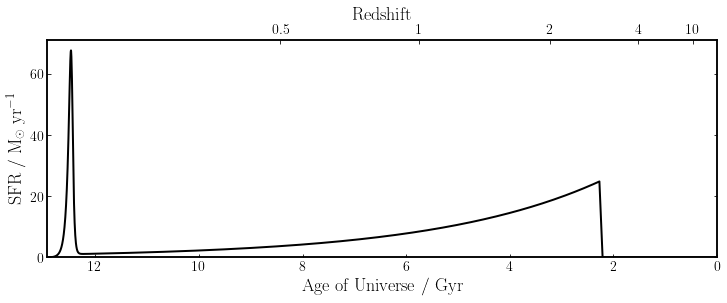

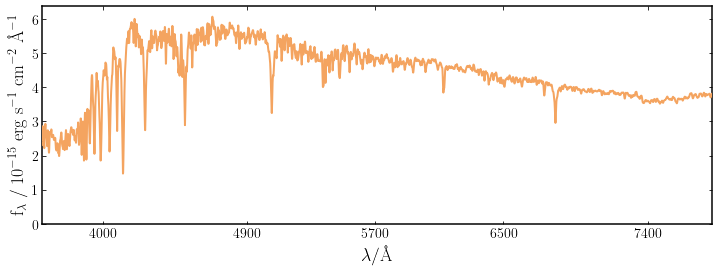

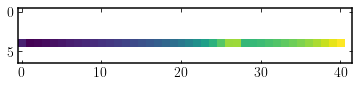

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'delta', 'metallicity': (0.01, 2.5), 'metallicity_prior': 'log_10'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


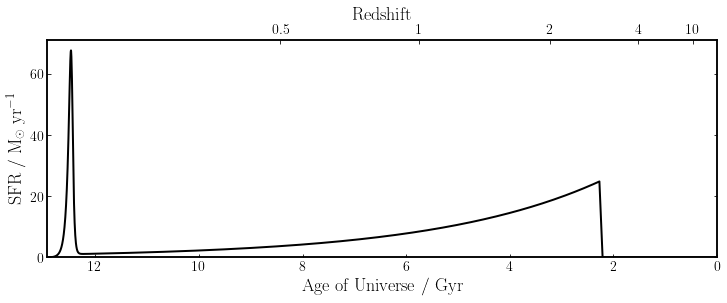

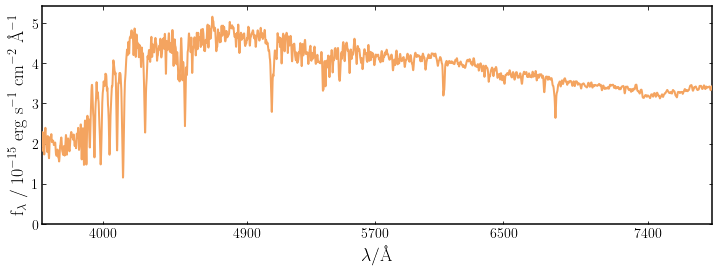

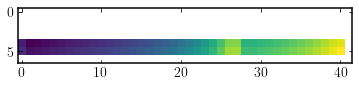

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'delta', 'metallicity': (0.01, 2.5), 'metallicity_prior': 'log_10'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


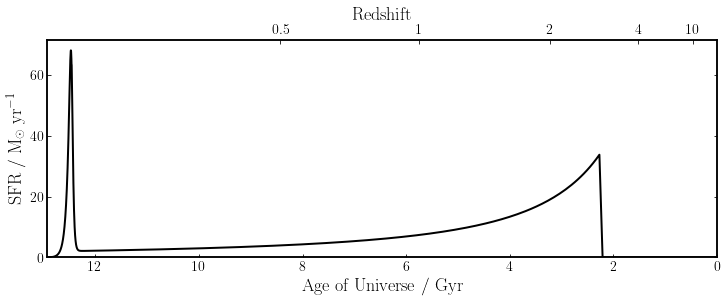

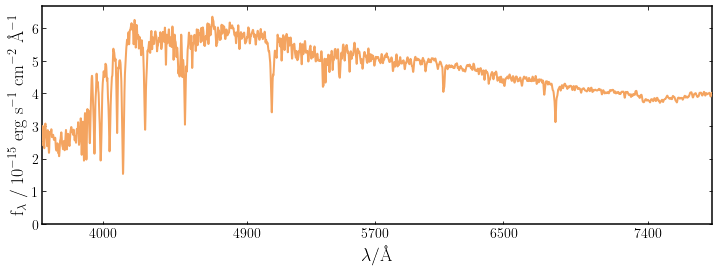

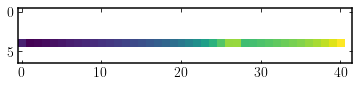

{'psb_twin': {'age': (4, 14.0), 'alpha1': (0.01, 5), 'alpha1_prior': 'log_10', 'beta1': 75236.0609, 'massformed': (6, 13), 'burstage': (0, 2), 'alpha2': (0.01, 1000), 'alpha2_prior': 'log_10', 'beta2': 500.0, 'fburst': (0, 1), 'metallicity_type': 'delta', 'metallicity': (0.01, 2.5), 'metallicity_prior': 'log_10'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


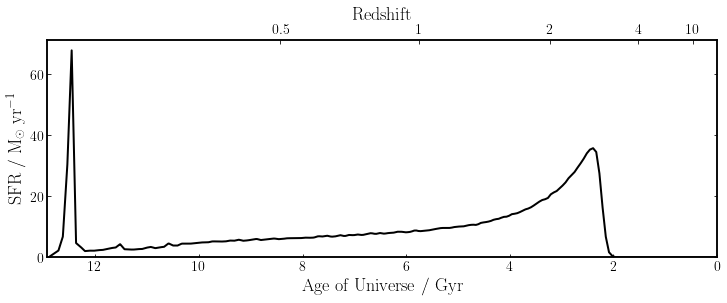

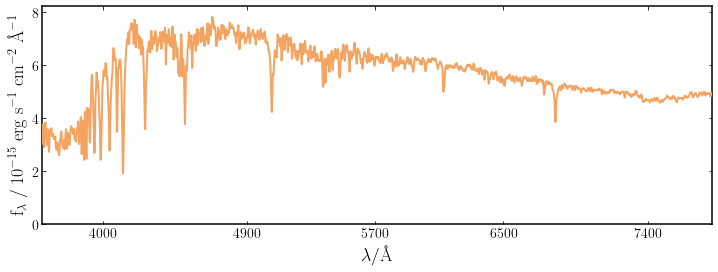

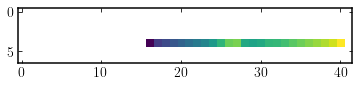

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'delta', 'metallicity': (0.01, 2.5), 'metallicity_prior': 'log_10'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


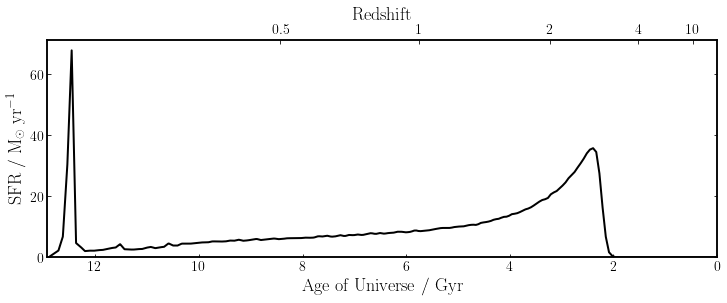

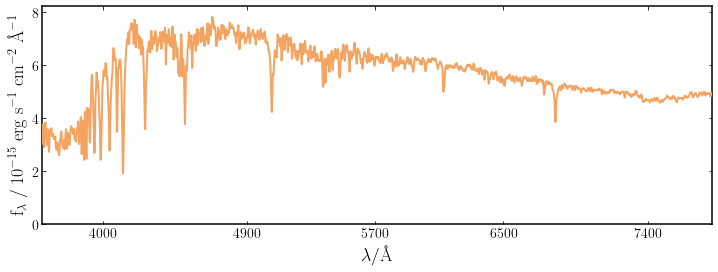

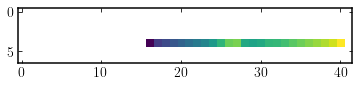

{'psb_twin': {'age': (4, 14.0), 'alpha1': (0.01, 5), 'alpha1_prior': 'log_10', 'beta1': 75236.0609, 'massformed': (6, 13), 'burstage': (0, 2), 'alpha2': (0.01, 1000), 'alpha2_prior': 'log_10', 'beta2': 500.0, 'fburst': (0, 1), 'metallicity_type': 'delta', 'metallicity': (0.01, 2.5), 'metallicity_prior': 'log_10'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


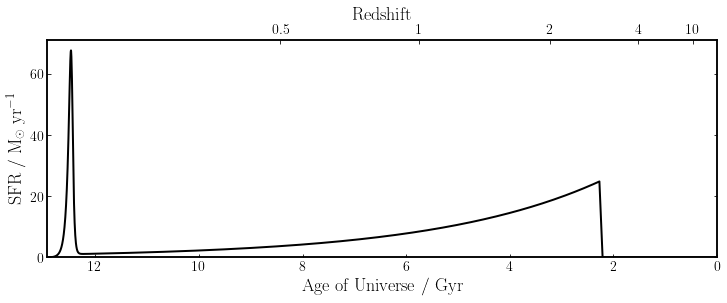

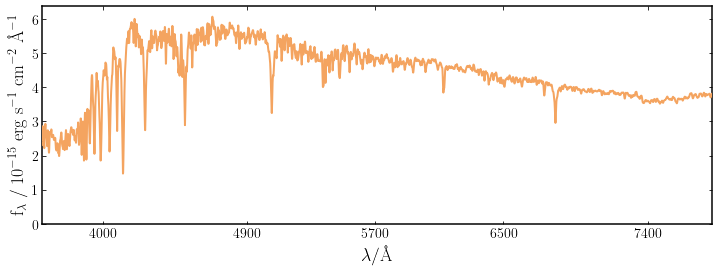

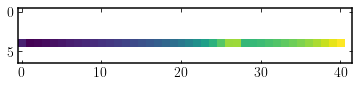

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


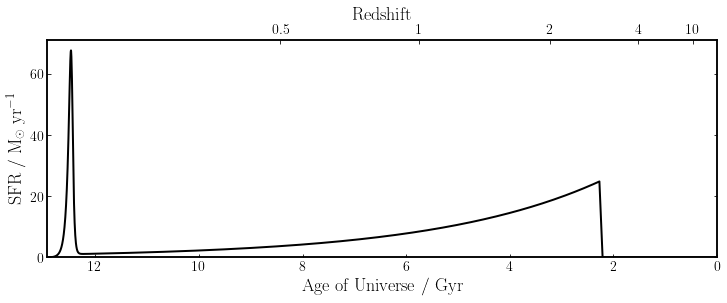

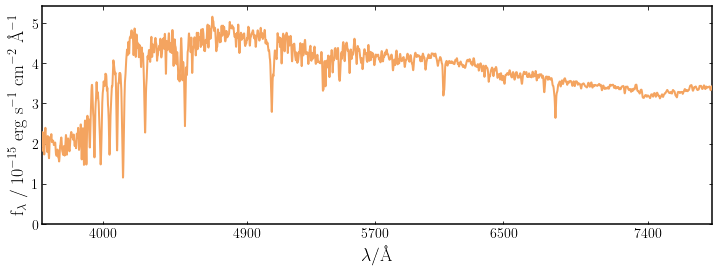

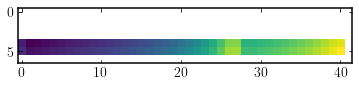

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


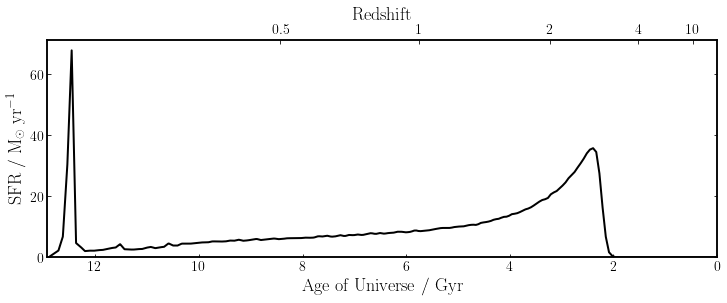

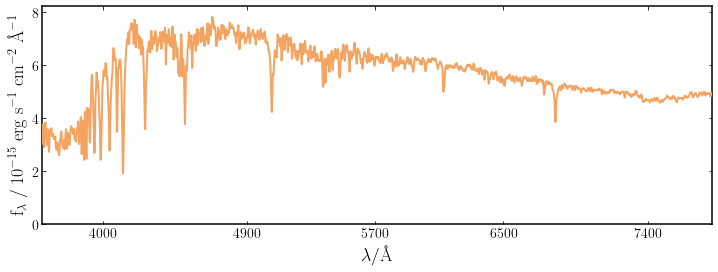

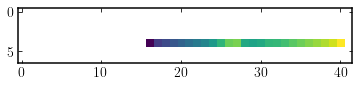

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


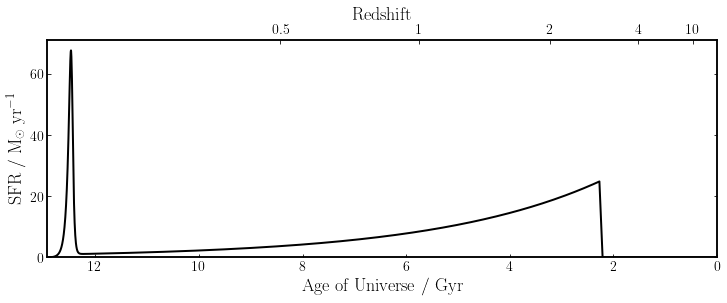

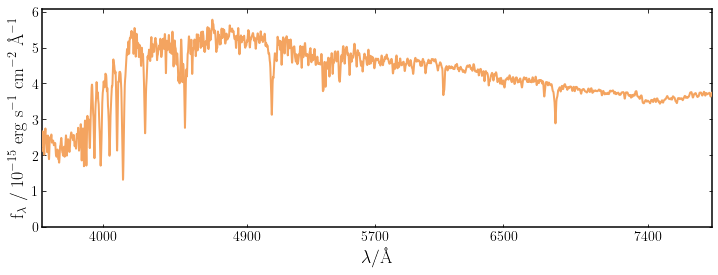

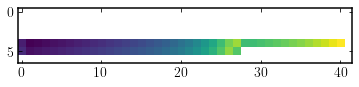

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


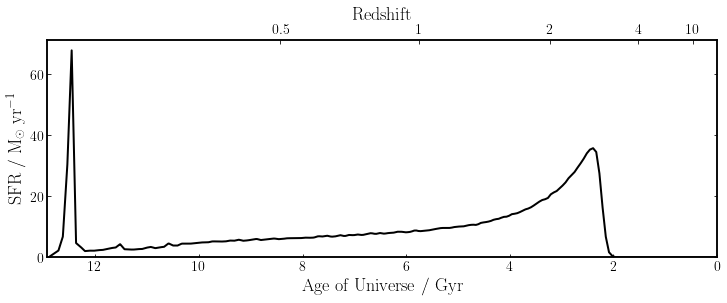

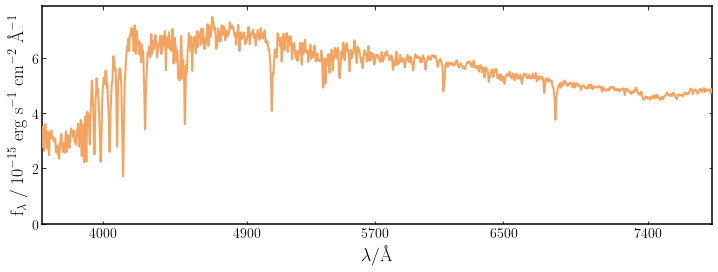

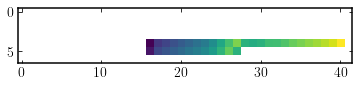

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


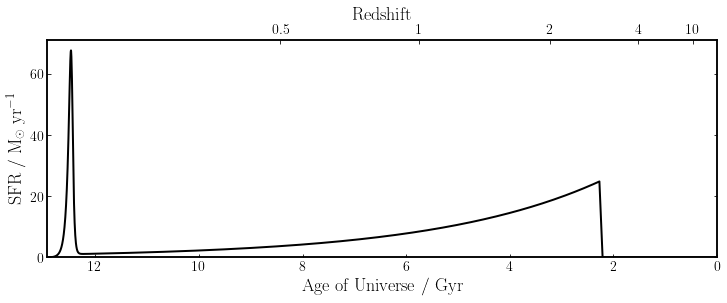

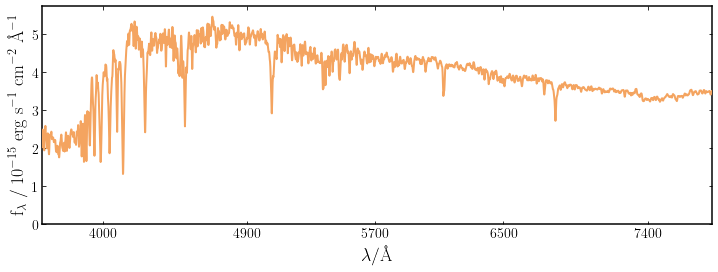

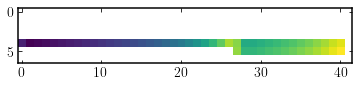

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'log_10', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


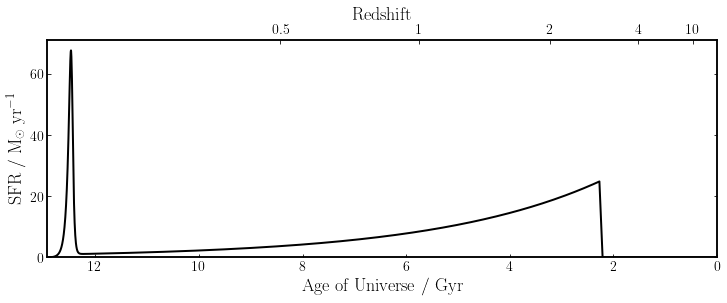

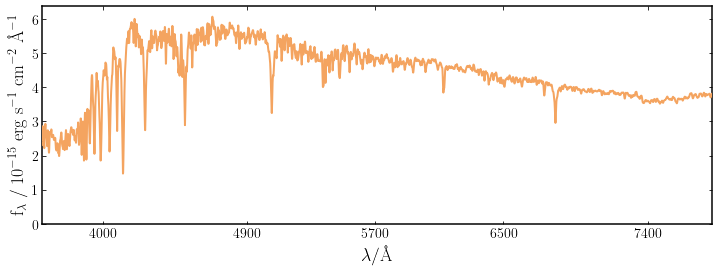

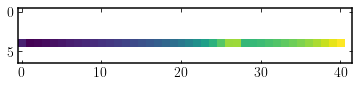

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_linear_step', 'metallicity_scatter': 'delta', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10', 'metallicity_slope': (-0.5, 0.5), 'metallicity_zero': (-0.5, 3.0)}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


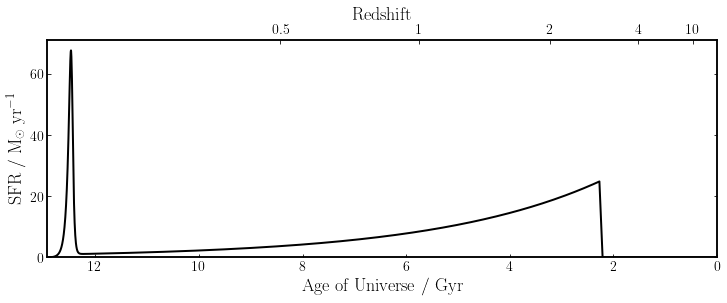

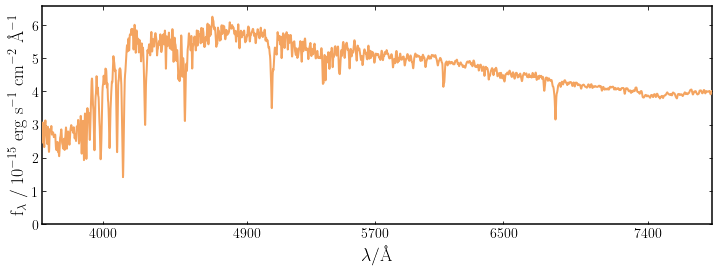

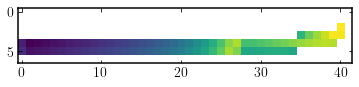

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_linear_step', 'metallicity_scatter': 'delta', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'log_10', 'metallicity_slope': (-0.5, 0.5), 'metallicity_zero': (-0.5, 3.0)}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


In [16]:
# creating models, setting up fit instructions
models = []
instructions = []
for i,row in fit_table.iterrows():
    models.append(gen_model(row, vb=True))
    fit_instructions = get_fit_instructions(row)
    print(fit_instructions)
    instructions.append(fit_instructions)

In [17]:
# actually fitting
for i,row in fit_table.iterrows():
    print(f'run {i+1} of {len(fit_table.index)}')
    psb_model = models[i]
    fit_instructions = instructions[i]
    fit_obj = fitting('../../..', psb_model, 
                  0.04, row['binby'], sky_masking=False, full=True,
                  model_galaxy_SNR=15)
    
    ID = row['galID']
    runID = row['runID']
    print('runID =', runID)
    
    galaxy = pipes.galaxy(ID, fit_obj.load_manga_spec, photometry_exists=False)
    pipes.config.Rspec = 4340
    fit = pipes.fit(galaxy, fit_instructions, run=runID)
    fit.fit(verbose=False, n_live=row['f_nlive'])

run 1 of 13
runID = psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn

Bagpipes: fitting object psb2_uniform1Zsun_veldisp100


Completed in 1421.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_wild2020:age               9.394     11.222     12.388
psb_wild2020:alpha           333.751    546.374    803.645
psb_wild2020:burstage          0.379      0.402      0.428
psb_wild2020:fburst            0.081      0.087      0.094
psb_wild2020:massformed       10.881     10.906     10.930
psb_wild2020:metallicity       1.000      1.087      1.199
psb_wild2020:tau               3.164      5.278      7.716
redshift                       0.040      0.040      0.040
veldisp                       95.290     99.817    104.414


run 2 of 13
runID = psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn

Bagpipes: fitting object psb2_uniform2Zsun_veldisp100


Complete


Completed in 4877.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_wild2020:age               7.297      9.011     11.023
psb_wild2020:alpha           222.592    404.780    740.212
psb_wild2020:burstage          0.376      0.409      0.468
psb_wild2020:fburst            0.078      0.087      0.099
psb_wild2020:massformed       10.907     10.954     11.001
psb_wild2020:metallicity_burst      1.269      1.720      2.181
psb_wild2020:metallicity_old      1.088      1.307      1.581
psb_wild2020:tau               4.515      6.868      9.005
redshift                       0.040      0.040      0.040
veldisp                       94.853     99.281    103.927


run 11 of 13
runID = psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn

Bagpipes: fitting object psb2_2step2to1Zsun_veldisp100


Completed in 3101.2 seconds.

Parameter                          

In [18]:
def plot_spec(fit, ID, runID, save=True):

    # check if GP noise is on
    GPon = False
    if 'noise' in fit.fit_instructions.keys():
        if fit.fit_instructions['noise']["type"] == "GP_exp_squared":
            GPon = True
    
    # Make the figure
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 16,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    get_advanced_quantities(fit)

    if GPon == False:
        fig = plt.figure(figsize=(12, 5.))
        gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
        ax1 = plt.subplot(gs1[:3])
        ax3 = plt.subplot(gs1[3])
    else:
        fig = plt.figure(figsize=(12, 6.))
        gs1 = matplotlib.gridspec.GridSpec(5, 1, hspace=0., wspace=0.)
        ax1 = plt.subplot(gs1[:3])
        ax3 = plt.subplot(gs1[3])
        ax4 = plt.subplot(gs1[4])

    mask = fit.galaxy.spectrum[:, 2] < 1.
    masked_spec = np.where(fit.galaxy.spectrum[:,2]>1)[0]
    fit.galaxy.spectrum[mask, 2] = 0.

    y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1, label='fitted obs spec')
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)
    non_masked_obs_spec = np.delete(fit.galaxy.spectrum, masked_spec, axis=0)
    if ax1.get_ylim()[0] < 0.9*min(non_masked_obs_spec[:,1])*10**-y_scale:
        ax1.set_ylim(bottom=0.9*min(non_masked_obs_spec[:,1])*10**-y_scale)
    if ax1.get_ylim()[1] > 1.1*max(non_masked_obs_spec[:,1])*10**-y_scale:
        ax1.set_ylim(top=1.1*max(non_masked_obs_spec[:,1])*10**-y_scale)

    if 'noise' in fit.posterior.samples.keys():
        post_median = np.median(fit.posterior.samples["spectrum"]+fit.posterior.samples["noise"], axis=0)
    else:
        post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #ax1.plot(fit.galaxy.spectrum[:,0],
    #         post_median*10**-y_scale,
    #         color="black", lw=1.0,zorder=11)
    
    #recover masks on spectrum and plot them as gray bands in residual plot
    mask_edges = [[masked_spec[0]],[]]
    for i,indi in enumerate(masked_spec[:-1]):
        if masked_spec[i+1] - indi > 1:
            mask_edges[1].append(indi)
            mask_edges[0].append(masked_spec[i+1])
    mask_edges[1].append(masked_spec[-1])
    mask_edges = np.array(mask_edges).T
    for [mask_min, mask_max] in mask_edges:
        ax3.fill_between([fit.galaxy.spectrum[:,0][mask_min], fit.galaxy.spectrum[:,0][mask_max]], 
                         [-10,-10], [10,10], color='lightgray', zorder=2)

    residuals = (fit.galaxy.spectrum[:,1] - post_median)*10**-y_scale
    non_masked_res = np.delete(residuals, masked_spec)
    ax3.axhline(0, color="black", ls="--", lw=1)
    ax3.plot(np.delete(fit.galaxy.spectrum[:,0], masked_spec), non_masked_res, color="sandybrown", zorder=1)
    #ax3.plot(fit.galaxy.spectrum[:,0], residuals, color="sandybrown",zorder=1)
    ax3.set_ylabel('residual')
    ax3.set_ylim([1.1*min(non_masked_res), 1.1*max(non_masked_res)])
    ax3.set_xlim(ax1.get_xlim())
    
    if GPon:
        # Plot the noise factor
        if 'noise' in fit.posterior.samples.keys():
            noise_percentiles = np.percentile(fit.posterior.samples['noise'],(16,50,84),axis=0)*10**-y_scale
            ax4.plot(fit.galaxy.spectrum[:,0], noise_percentiles[1],color="sandybrown", zorder=1)
            ax4.fill_between(fit.galaxy.spectrum[:,0], noise_percentiles[0], noise_percentiles[2], 
                             color='navajowhite', zorder=-1)
        ax4.axhline(0, color="black", ls="--", lw=1)

        ax4_ylims = ax4.get_ylim()
        for [mask_min, mask_max] in mask_edges:
            ax4.fill_between([fit.galaxy.spectrum[:,0][mask_min], fit.galaxy.spectrum[:,0][mask_max]], 
                             [-10,-10], [10,10], color='lightgray', zorder=2)
        ax4.set_xlim(ax1.get_xlim())
        ax4.set_ylim(ax4_ylims)
        pipes.plotting.auto_x_ticks(ax4)
        ax4.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
        ax4.set_ylabel('noise')
    
    if save:
        fig.savefig('pipes/plots/'+runID+'/'+ID+'_fit.pdf')
    plt.show()

m_SFH                                                psb_wild2020
m_CEH                                                       delta
m_zmet_old                                                      1
m_zmet_burst                                                  NaN
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       delta
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                                psb2_uniform1Zsun_veldisp100
runID     

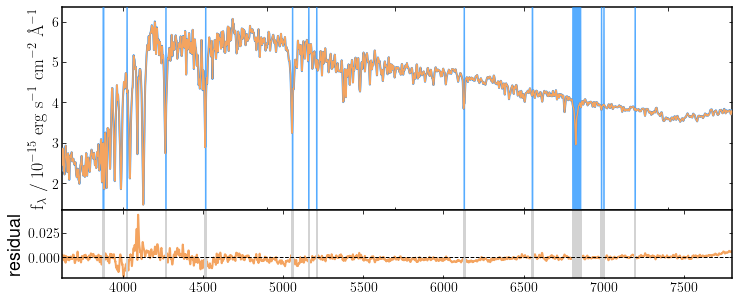

only recovered 0.9431210756519637 of total mass formed.
10.907384404152724 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477387693656665
posterior f_burst and t_burst: [0.08144068 0.08719814 0.094561  ] [12.4945307  12.52221469 12.54447134]


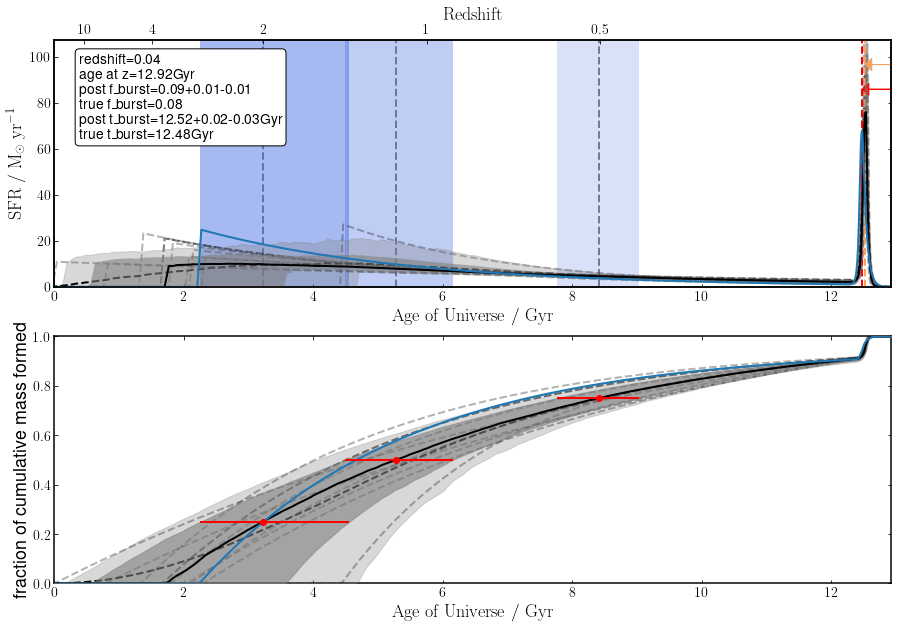

m_SFH                                                psb_wild2020
m_CEH                                                       delta
m_zmet_old                                                      2
m_zmet_burst                                                  NaN
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       delta
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                                psb2_uniform2Zsun_veldisp100
runID     

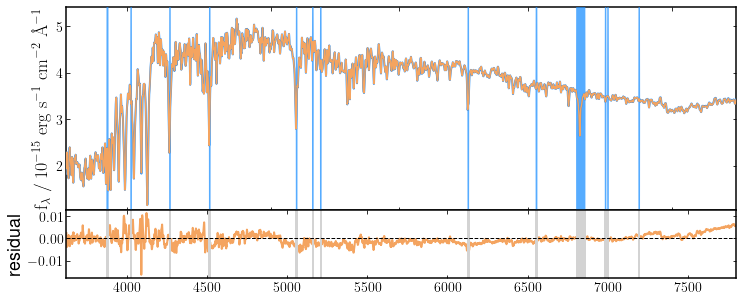

only recovered 0.9393504742688247 of total mass formed.
10.905644613116628 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477378056523976
posterior f_burst and t_burst: [0.07760892 0.08336228 0.0909491 ] [12.47340141 12.52445119 12.55459749]


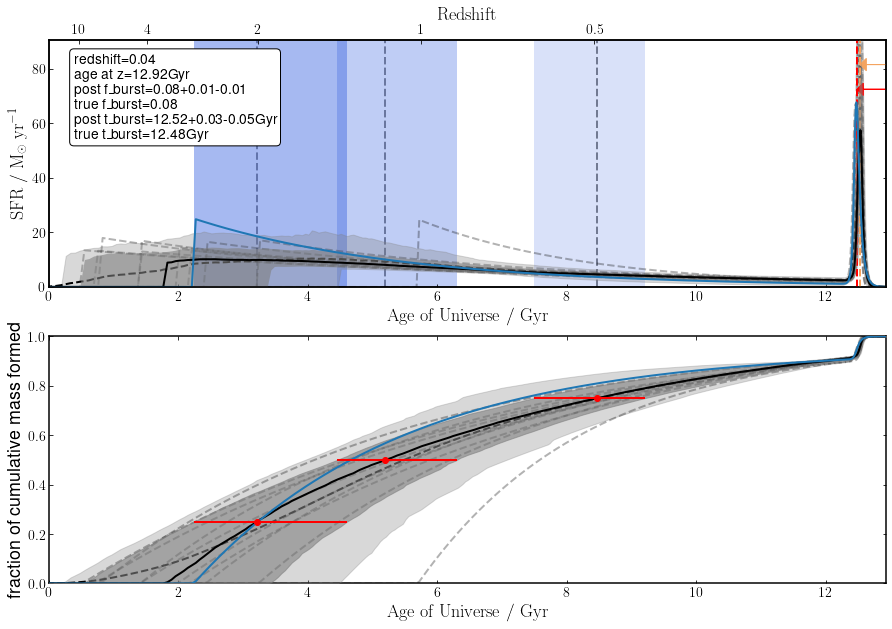

m_SFH                                                    psb_twin
m_CEH                                                       delta
m_zmet_old                                                      1
m_zmet_burst                                                  NaN
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                    psb_twin
f_CEH                                                       delta
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                             psbtwin_uniform1Zsun_veldisp100
runID     

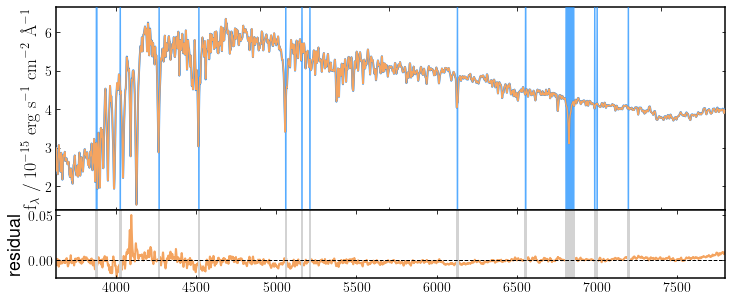

only recovered 0.9106512552935796 of total mass formed.
10.90680189908271 10.947449808497407
model f_burst and t_burst: 0.08699754064360947 12.456563813691771
posterior f_burst and t_burst: [0.07727226 0.08446075 0.09362303] [12.50048396 12.52683286 12.54841261]


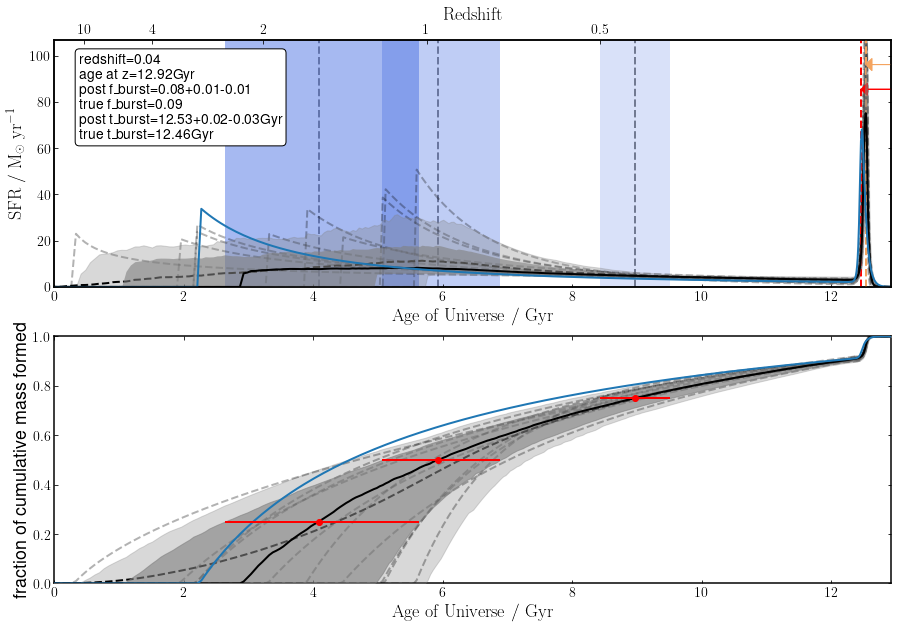

m_SFH                                                       yirui
m_CEH                                                       delta
m_zmet_old                                                      1
m_zmet_burst                                                  NaN
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       delta
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                               yirui_uniform1Zsun_veldisp100
runID     

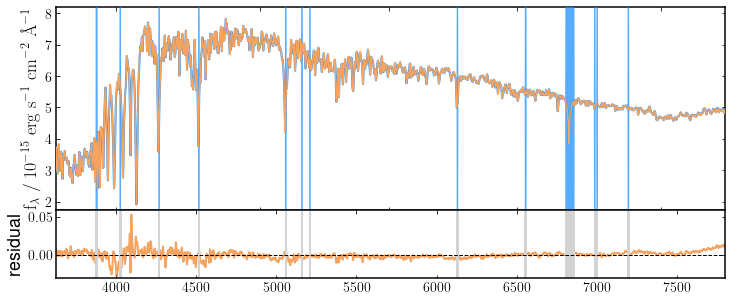

only recovered 0.9144105349032395 of total mass formed.
10.988376061083834 11.027234840170811
model f_burst and t_burst: 0.08865578690294339 12.441374271277052
posterior f_burst and t_burst: [0.07535044 0.08145996 0.08820676] [12.48642766 12.52420882 12.55783276]


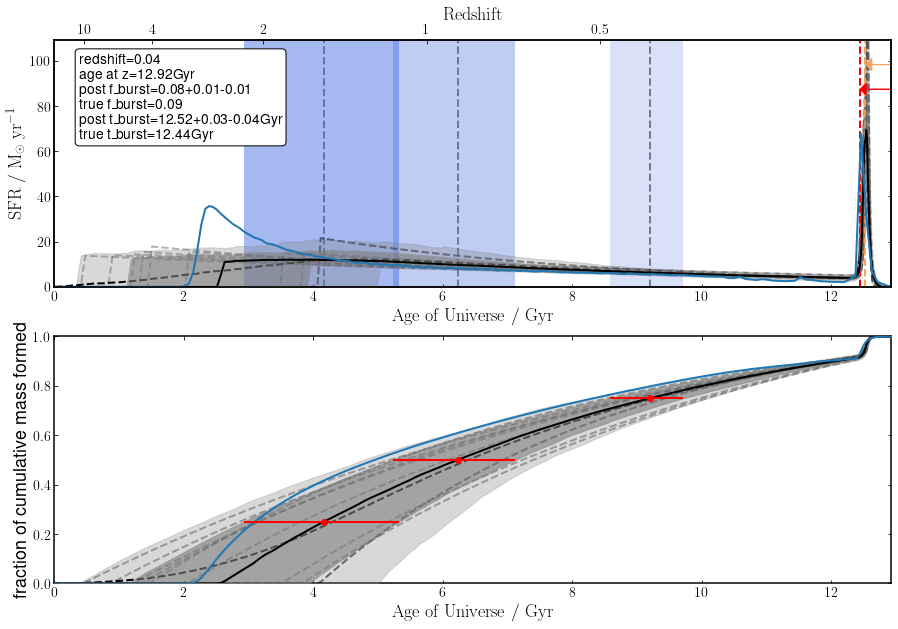

m_SFH                                                       yirui
m_CEH                                                       delta
m_zmet_old                                                      1
m_zmet_burst                                                  NaN
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                    psb_twin
f_CEH                                                       delta
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                               yirui_uniform1Zsun_veldisp100
runID     

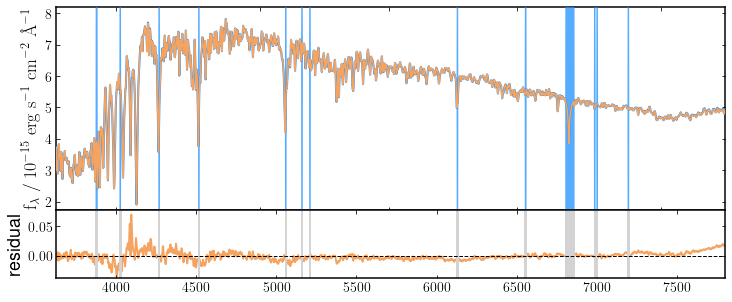

only recovered 0.8708953672941189 of total mass formed.
10.96720082050978 11.027234840170811
model f_burst and t_burst: 0.089153644419279 12.441255035465977
posterior f_burst and t_burst: [0.06893648 0.0771377  0.08762676] [12.50250674 12.54504287 12.57184695]


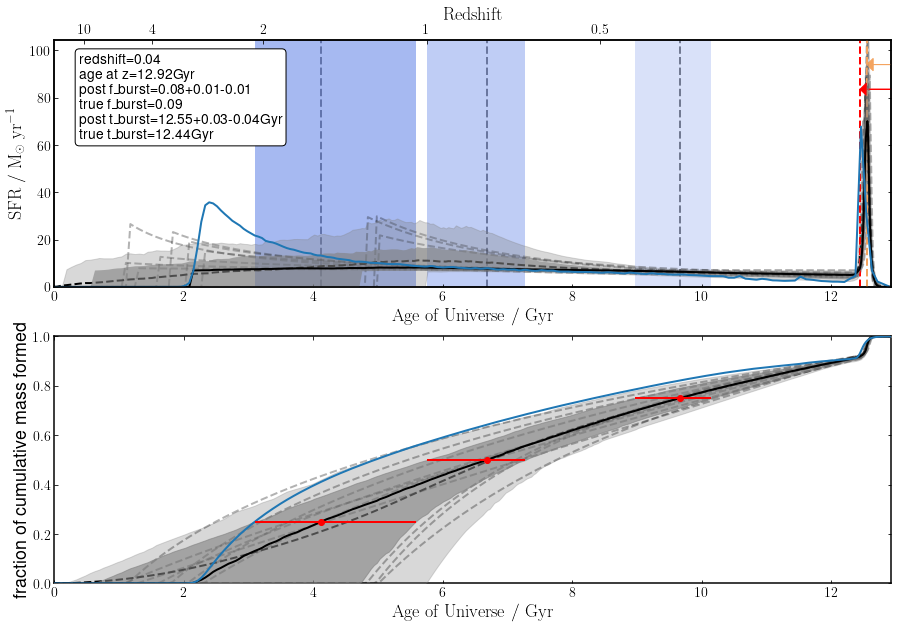

m_SFH                                                psb_wild2020
m_CEH                                                       delta
m_zmet_old                                                      1
m_zmet_burst                                                  NaN
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       2step
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                                psb2_uniform1Zsun_veldisp100
runID     

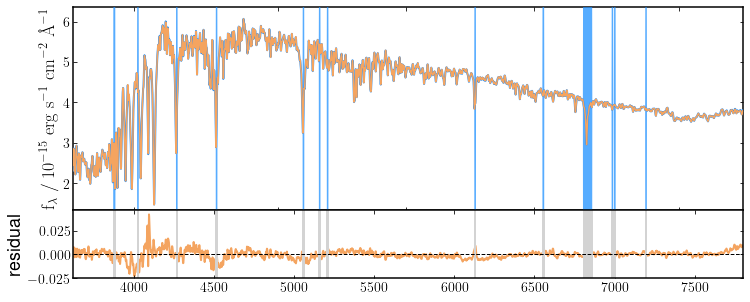

only recovered 0.9193884665955483 of total mass formed.
10.89631600551559 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477390769039792
posterior f_burst and t_burst: [0.08111685 0.08773213 0.09513122] [12.51048755 12.52872371 12.54283169]


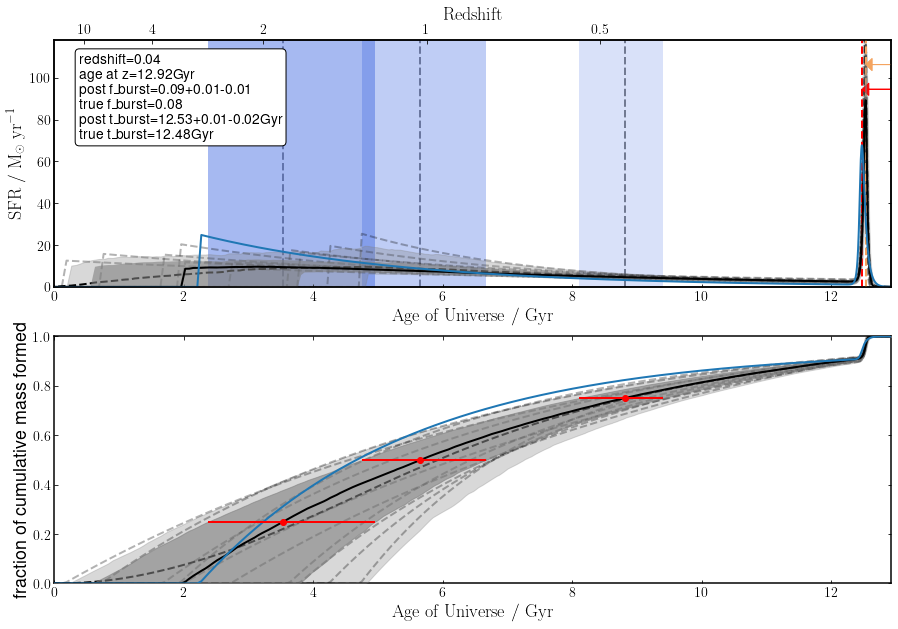

m_SFH                                                psb_wild2020
m_CEH                                                       delta
m_zmet_old                                                      2
m_zmet_burst                                                  NaN
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       2step
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                                psb2_uniform2Zsun_veldisp100
runID     

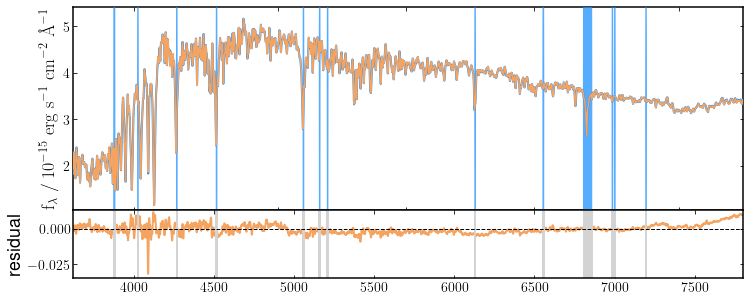

only recovered 0.8941225674059659 of total mass formed.
10.884214010629488 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477386852563447
posterior f_burst and t_burst: [0.07860667 0.08612163 0.09624892] [12.48654415 12.52811143 12.55443892]


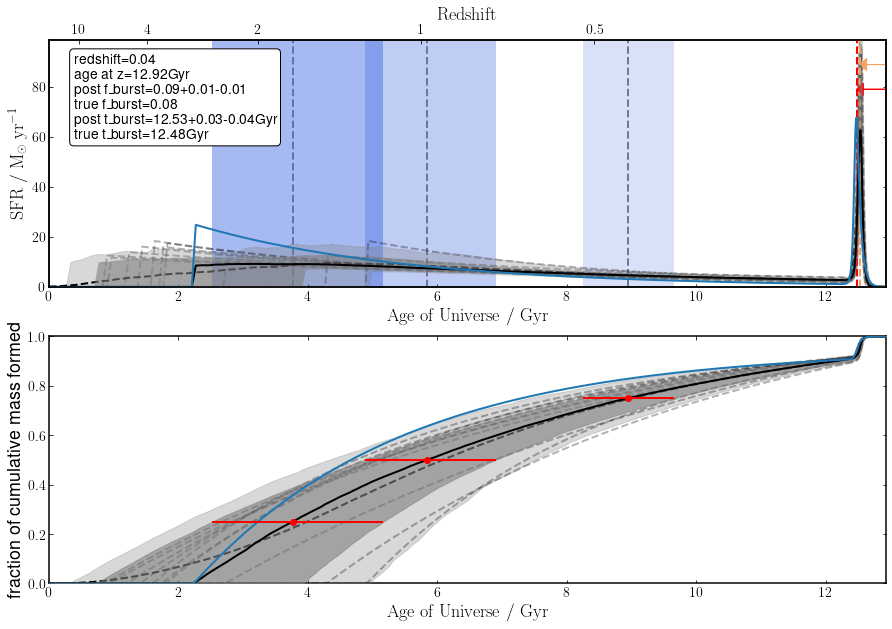

m_SFH                                                       yirui
m_CEH                                                       delta
m_zmet_old                                                      1
m_zmet_burst                                                  NaN
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       2step
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                               yirui_uniform1Zsun_veldisp100
runID     

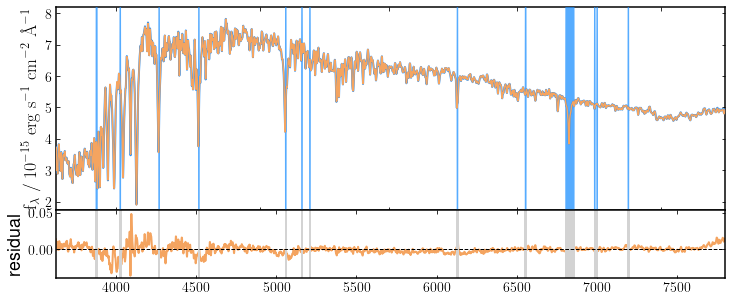

only recovered 0.9065011455006581 of total mass formed.
10.98460319739914 11.027234840170811
model f_burst and t_burst: 0.08865578690294339 12.441369369572097
posterior f_burst and t_burst: [0.07450399 0.08106208 0.08874577] [12.51870159 12.54020422 12.55723284]


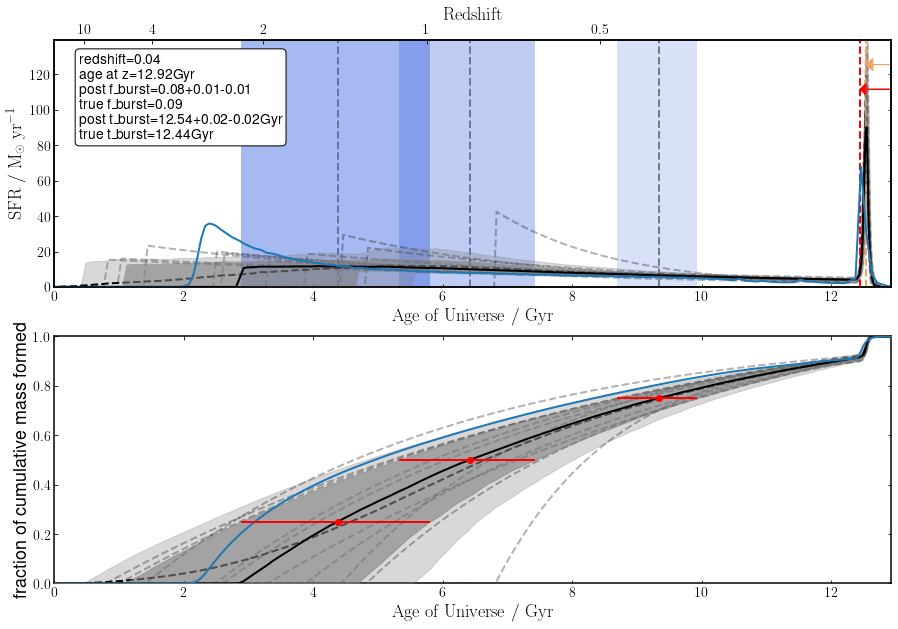

m_SFH                                                psb_wild2020
m_CEH                                                       2step
m_zmet_old                                                      1
m_zmet_burst                                                    2
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       2step
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                               psb2_2step1to2Zsun_veldisp100
runID     

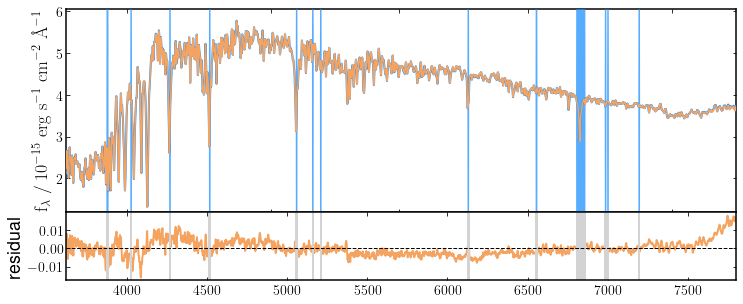

only recovered 0.8813602352606466 of total mass formed.
10.877970406488346 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477406884924113
posterior f_burst and t_burst: [0.08499125 0.09383131 0.1073108 ] [12.45466352 12.49444682 12.52457004]


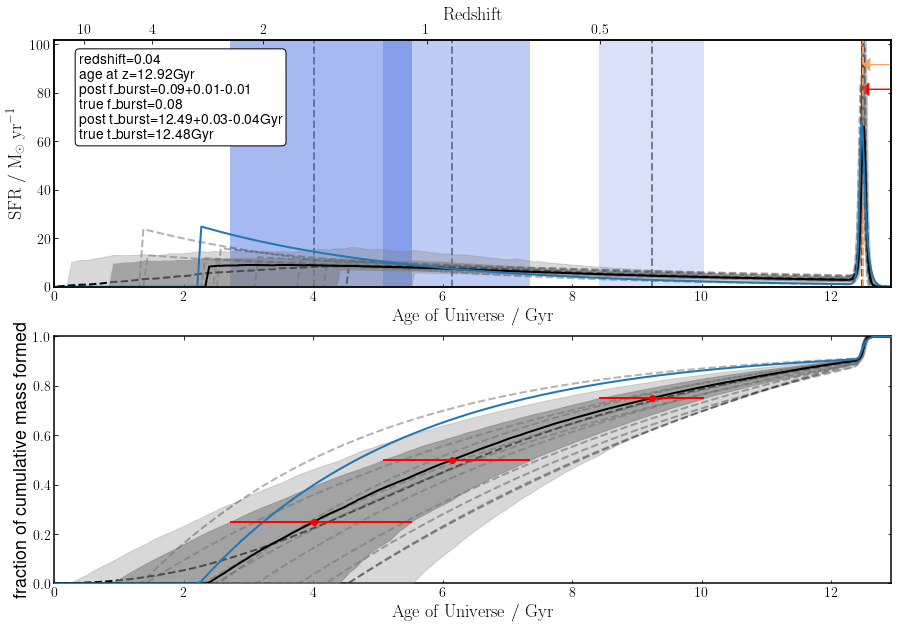

m_SFH                                                       yirui
m_CEH                                                       2step
m_zmet_old                                                      1
m_zmet_burst                                                    2
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       2step
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                              yirui_2step1to2Zsun_veldisp100
runID     

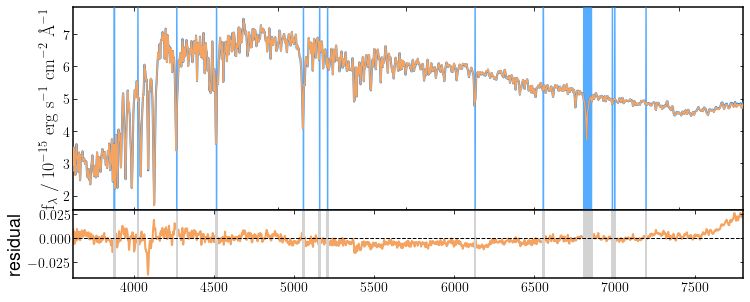

only recovered 0.8352976898583928 of total mass formed.
10.94907612047151 11.027234840170811
model f_burst and t_burst: 0.08865578690294339 12.441397618927256
posterior f_burst and t_burst: [0.07859019 0.08741258 0.10211921] [12.44883179 12.51450094 12.54592895]


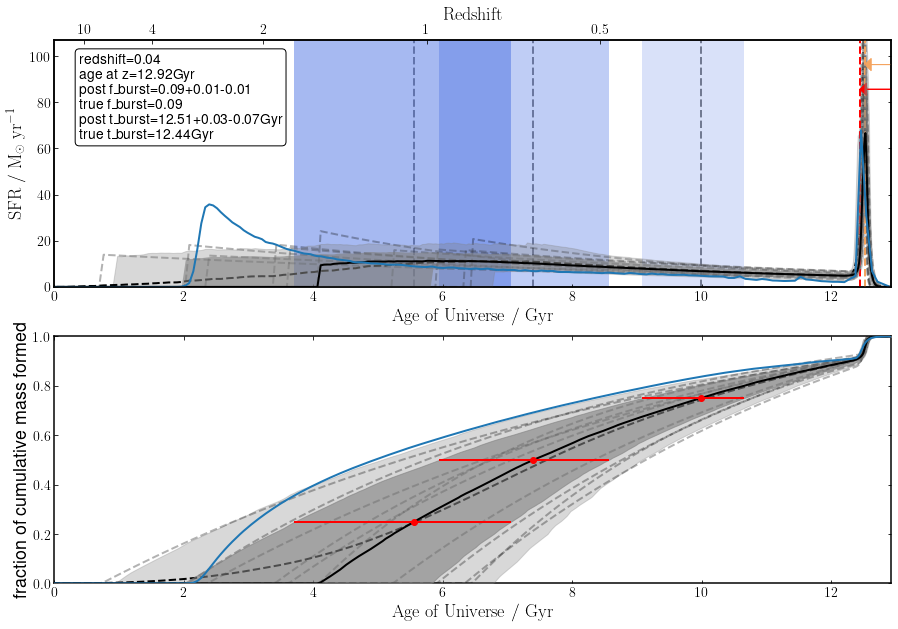

m_SFH                                                psb_wild2020
m_CEH                                                       2step
m_zmet_old                                                      2
m_zmet_burst                                                    1
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       2step
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                               psb2_2step2to1Zsun_veldisp100
runID     

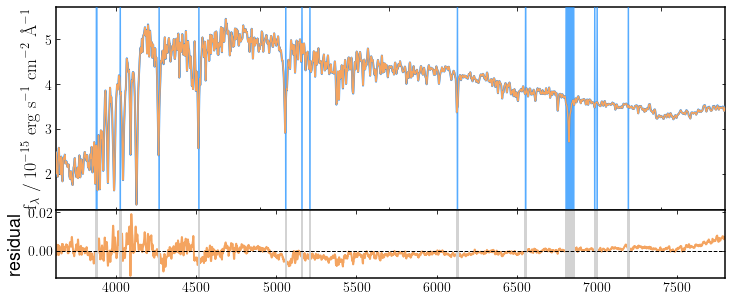

only recovered 0.9451967623904753 of total mass formed.
10.908339179499979 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477368590577047
posterior f_burst and t_burst: [0.07954062 0.08492997 0.09216817] [12.51105961 12.52290322 12.53491509]


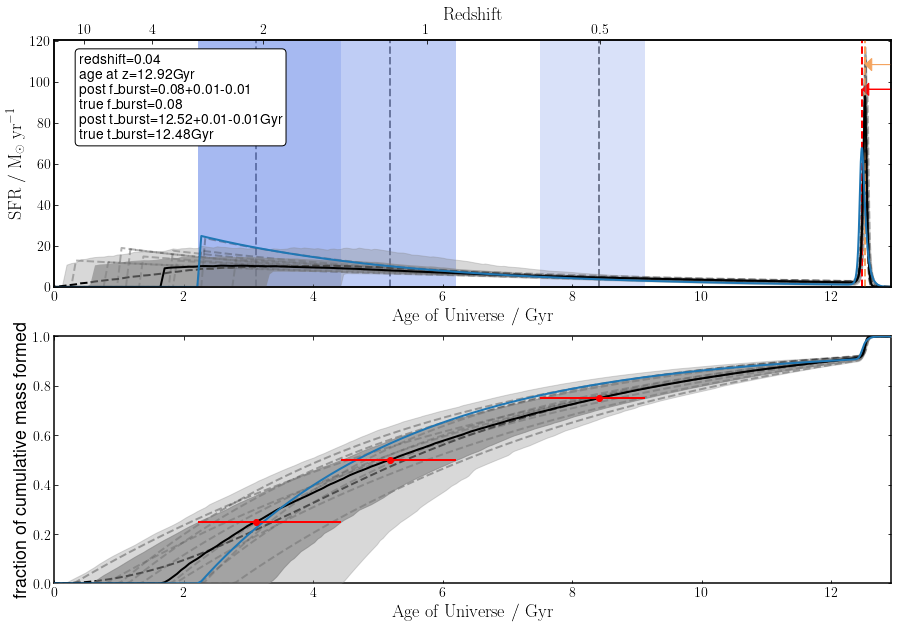

m_SFH                                                psb_wild2020
m_CEH                                                       delta
m_zmet_old                                                      1
m_zmet_burst                                                  NaN
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                 slope+2step
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                                psb2_uniform1Zsun_veldisp100
runID     

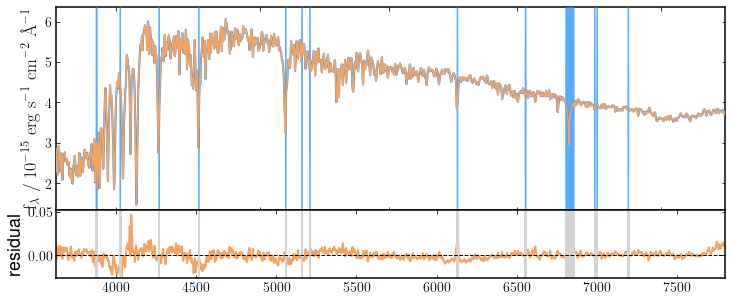

only recovered 0.9025175198396662 of total mass formed.
10.888272595404025 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477387824950688
posterior f_burst and t_burst: [0.08307687 0.09044126 0.09963815] [12.50855777 12.52459526 12.54013592]


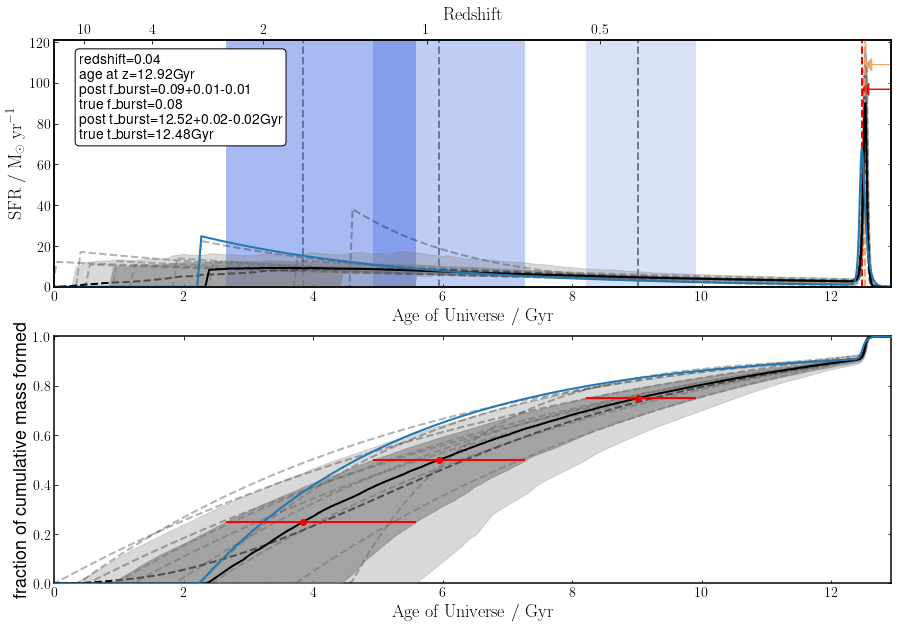

m_SFH                                                psb_wild2020
m_CEH                                                 slope+2step
m_zmet_old                                                   auto
m_zmet_burst                                                    2
m_zmet_slope                                                 -0.1
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                 slope+2step
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                                 psb2_slope+2step_veldisp100
runID     

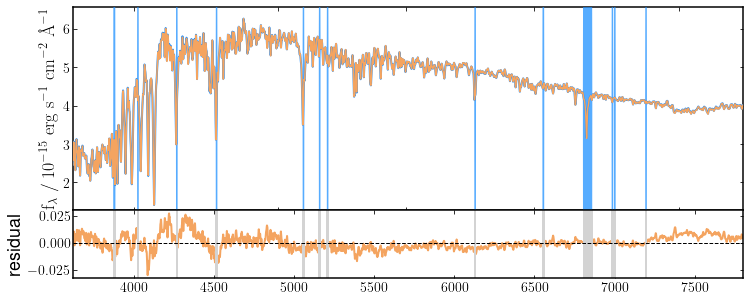

only recovered 0.809552896102676 of total mass formed.
10.841062184911543 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477403469381661
posterior f_burst and t_burst: [0.08000094 0.08962707 0.10112588] [12.45415062 12.5033473  12.53284538]


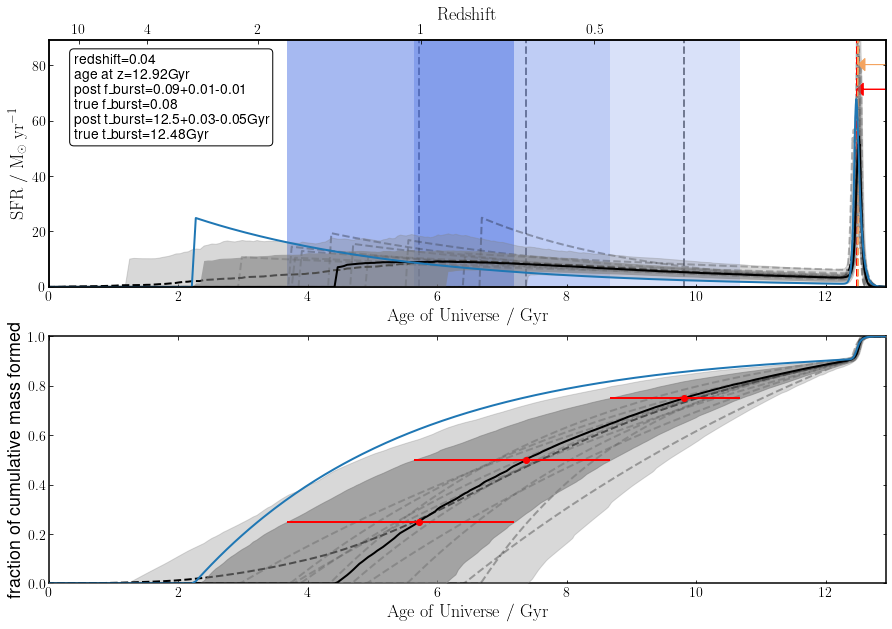

In [19]:
pipes.plotting.latex_names["metallicity_slope"] = "\\mathrm{Z_{slope}}"
pipes.plotting.latex_units["metallicity_slope"] = "Z_{\\odot}\\ Gyr^{-1}"
pipes.plotting.latex_names["metallicity_zero"] = "\\mathrm{Z_{0}}"
pipes.plotting.latex_units["metallicity_zero"] = "Z_{\\odot}"

import os
for i,row in fit_table.iterrows():
    if row['old_fit']:
        # all old_fits are only using psb_twin for model creation
        psb_twin_popt = [1.26348321e+01, 8.70221355e-01, 9.64793965e+03, 5.53510051e-01, 
                         1.83730405e+02, 6.79456054e+02, 8.64240632e-02, 1.10272314e+01]
        psb_model = gen_model(row, vb=False, old_fit_params=psb_twin_popt)
    else:
        psb_model = models[i]
    fit_obj = fitting('../../..', psb_model, 
                  0.04, row['binby'], sky_masking=False, full=True,
                  model_galaxy_SNR=15)
    
    ID = row['galID']
    runID = row['runID']
    print(row)
    print('runID =', runID)
    
    galaxy = pipes.galaxy(ID, fit_obj.load_manga_spec, photometry_exists=False)
    pipes.config.Rspec = 4340
    fit = pipes.fit(galaxy, {}, run=runID)
    
    if f'{ID}_fit.pdf' not in os.listdir(f'pipes/plots/{runID}'):
        plot_spec(fit, ID, runID)
    if f'{ID}_corner.pdf' not in os.listdir(f'pipes/plots/{runID}'):
        fig = fit.plot_corner(save=True, show=True)
    if f'{ID}_combined_sfh.pdf' not in os.listdir(f'pipes/plots/{runID}'):
        plot_sfh(fit, psb_model.sfh.ages*10**-9, psb_model.sfh.sfh,
                 ID, runID, samples=10, plot_mean=True, ninty_region=True)

In [96]:
# create master dataframe to hold all samples
samps_df_list = []
for i,row in fit_table.iterrows():
    psb_model = models[i]
    fit_obj = fitting('../../..', psb_model, 
                  0.04, row['binby'], sky_masking=False, full=True,
                  model_galaxy_SNR=15)
    
    ID = row['galID']
    runID = row['runID']
    galaxy = pipes.galaxy(ID, fit_obj.load_manga_spec, photometry_exists=False)
    pipes.config.Rspec = 4340
    fit = pipes.fit(galaxy, {}, run=runID)
    
    samps = fit.posterior.samples.copy()
    for key in ['sfh', 'spectrum', 'mass_weighted_age', 'tform', 'tquench', 
                'spectrum_full', 'uvj', 'formed_mass']:
        samps.pop(key, None)
    samps_df = pd.DataFrame(samps)
    for col in samps_df.columns:
        if ':' in col:
            samps_df.rename(columns={col: col.split(':')[1]}, inplace=True)
    samps_df.rename(columns={'alpha': 'alpha2', 'metallicity':'metallicity_old', 
                             'metallicity_zero':'metallicity_old'}, inplace=True)
    samps_df['galID'] = ID
    samps_df['runID'] = runID
    samps_df['fit_order'] = i
    samps_df_list.append(samps_df)
    
post_df = pd.concat(samps_df_list, ignore_index=True)
post_df = post_df[['massformed', 'fburst', 'age', 'tau', 'alpha1', 'burstage', 'alpha2', 
                  'metallicity_old', 'metallicity_burst', 'metallicity_slope', 'redshift',
                  'veldisp', 'stellar_mass', 'sfr', 'ssfr', 'nsfr', 'galID', 'runID', 'fit_order']]
post_df
    


Results loaded from pipes/posterior/psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn/psb2_uniform1Zsun_veldisp100.h5


Results loaded from pipes/posterior/psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn/psb2_uniform2Zsun_veldisp100.h5


Results loaded from pipes/posterior/psbtwin_delta_nlive400_bin_by_1_4340_Rspec_veldispOn/psbtwin_uniform1Zsun_veldisp100.h5


Results loaded from pipes/posterior/psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn/yirui_uniform1Zsun_veldisp100.h5


Results loaded from pipes/posterior/psbtwin_delta_nlive400_bin_by_1_4340_Rspec_veldispOn/yirui_uniform1Zsun_veldisp100.h5


Results loaded from pipes/posterior/psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn/psb2_uniform1Zsun_veldisp100.h5


Results loaded from pipes/posterior/psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn/psb2_uniform2Zsun_veldisp100.h5


Results loaded from pipes/posterior/psb2_2step_nlive400_bin_by_1_4340_Rspec_veldispOn/yirui_uniform1Zsun_veldisp100.h5


Results loaded from pipes/p

massformed    fburst        age       tau  alpha1  burstage      alpha2  \
0      10.898907  0.085086  10.723573  5.198835     NaN  0.387634  783.492086   
1      10.906257  0.083198  11.385067  5.451965     NaN  0.399940  803.366270   
2      10.874510  0.086750  10.037313  5.597344     NaN  0.383069  686.951533   
3      10.890995  0.096656   7.488181  1.433733     NaN  0.413257  692.759151   
4      10.909481  0.080240  12.410149  8.348807     NaN  0.387143  723.111376   
...          ...       ...        ...       ...     ...       ...         ...   
6495   10.826621  0.095665   8.543928  5.844729     NaN  0.409727  496.631592   
6496   10.889512  0.101689   8.558229  2.271006     NaN  0.430211  370.647421   
6497   10.811400  0.085611   8.369806  9.104933     NaN  0.431863  921.334512   
6498   10.905342  0.076469  11.707689  8.067535     NaN  0.422731  332.017279   
6499   10.782661  0.073869   6.197632  4.354017     NaN  0.413182  300.215166   

      metallicity_old  metallicity_burst  metallicity_slope  redshift  \
0            1.021537                NaN                NaN  0.040011   
1            0.930938                NaN                NaN  0.040005   
2            1.114466                NaN                NaN  0.039997   
3            0.944159                NaN                NaN  0.039994   
4            1.041221                NaN                NaN  0.039993   
...               ...                ...                ...       ...   
6495         1.761131           1.755588          -0.195329  0.039982   
6496         1.919481           1.818334          -0.203909  0.039985   
6497         1.214588           1.227504          -0.119995  0.040003   
6498         1.133894           1.764694          -0.078404  0.039993   
6499         0.729458           1.839575           0.016188  0.040000   

         veldisp  stellar_mass           sfr       ssfr      nsfr  \
0      95.931400     10.596399  6.364857e-07 -16.792610 -6.983724   
1     100.277374     10.599617  1.803590e-07 -17.343479 -7.538723   
2      95.815471     10.575840  7.650119e-06 -15.692172 -5.879441   
3     105.835122     10.591345  1.460794e-06 -16.426756 -6.615004   
4      91.488930     10.603648  2.622153e-06 -16.184990 -6.379421   
...          ...           ...           ...        ...       ...   
6495  106.742060     10.528698  2.178314e-04 -14.190577 -4.377094   
6496  103.250124     10.578778  3.497287e-03 -13.035046 -3.234375   
6497  111.107861     10.517179  7.932763e-10 -19.617755 -9.800578   
6498  102.780190     10.590265  9.296377e-03 -12.621951 -2.825626   
6499  101.354262     10.501523  1.934734e-02 -12.214902 -2.384640   

                             galID  \
0     psb2_uniform1Zsun_veldisp100   
1     psb2_uniform1Zsun_veldisp100   
2     psb2_uniform1Zsun_veldisp100   
3     psb2_uniform1Zsun_veldisp100   
4     psb2_uniform1Zsun_veldisp100   
...                            ...   
6495   psb2_slope+2step_veldisp100   
6496   psb2_slope+2step_veldisp100   
6497   psb2_slope+2step_veldisp100   
6498   psb2_slope+2step_veldisp100   
6499   psb2_slope+2step_veldisp100   

                                                  runID  fit_order  
0     psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn          0  
1     psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn          0  
2     psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn          0  
3     psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn          0  
4     psb2_delta_nlive400_bin_by_1_4340_Rspec_veldispOn          0  
...                                                 ...        ...  
6495  psb2_slope+2step_nlive400_bin_by_1_4340_Rspec_...         12  
6496  psb2_slope+2step_nlive400_bin_by_1_4340_Rspec_...         12  
6497  psb2_slope+2step_nlive400_bin_by_1_4340_Rspec_...         12  
6498  psb2_slope+2step_nlive400_bin_by_1_4340_Rspec_...         12  
6499  psb2_slope+2step_nlive400_bin_by_1_4340_Rspec_...         12  

[6500 rows x 19 columns]

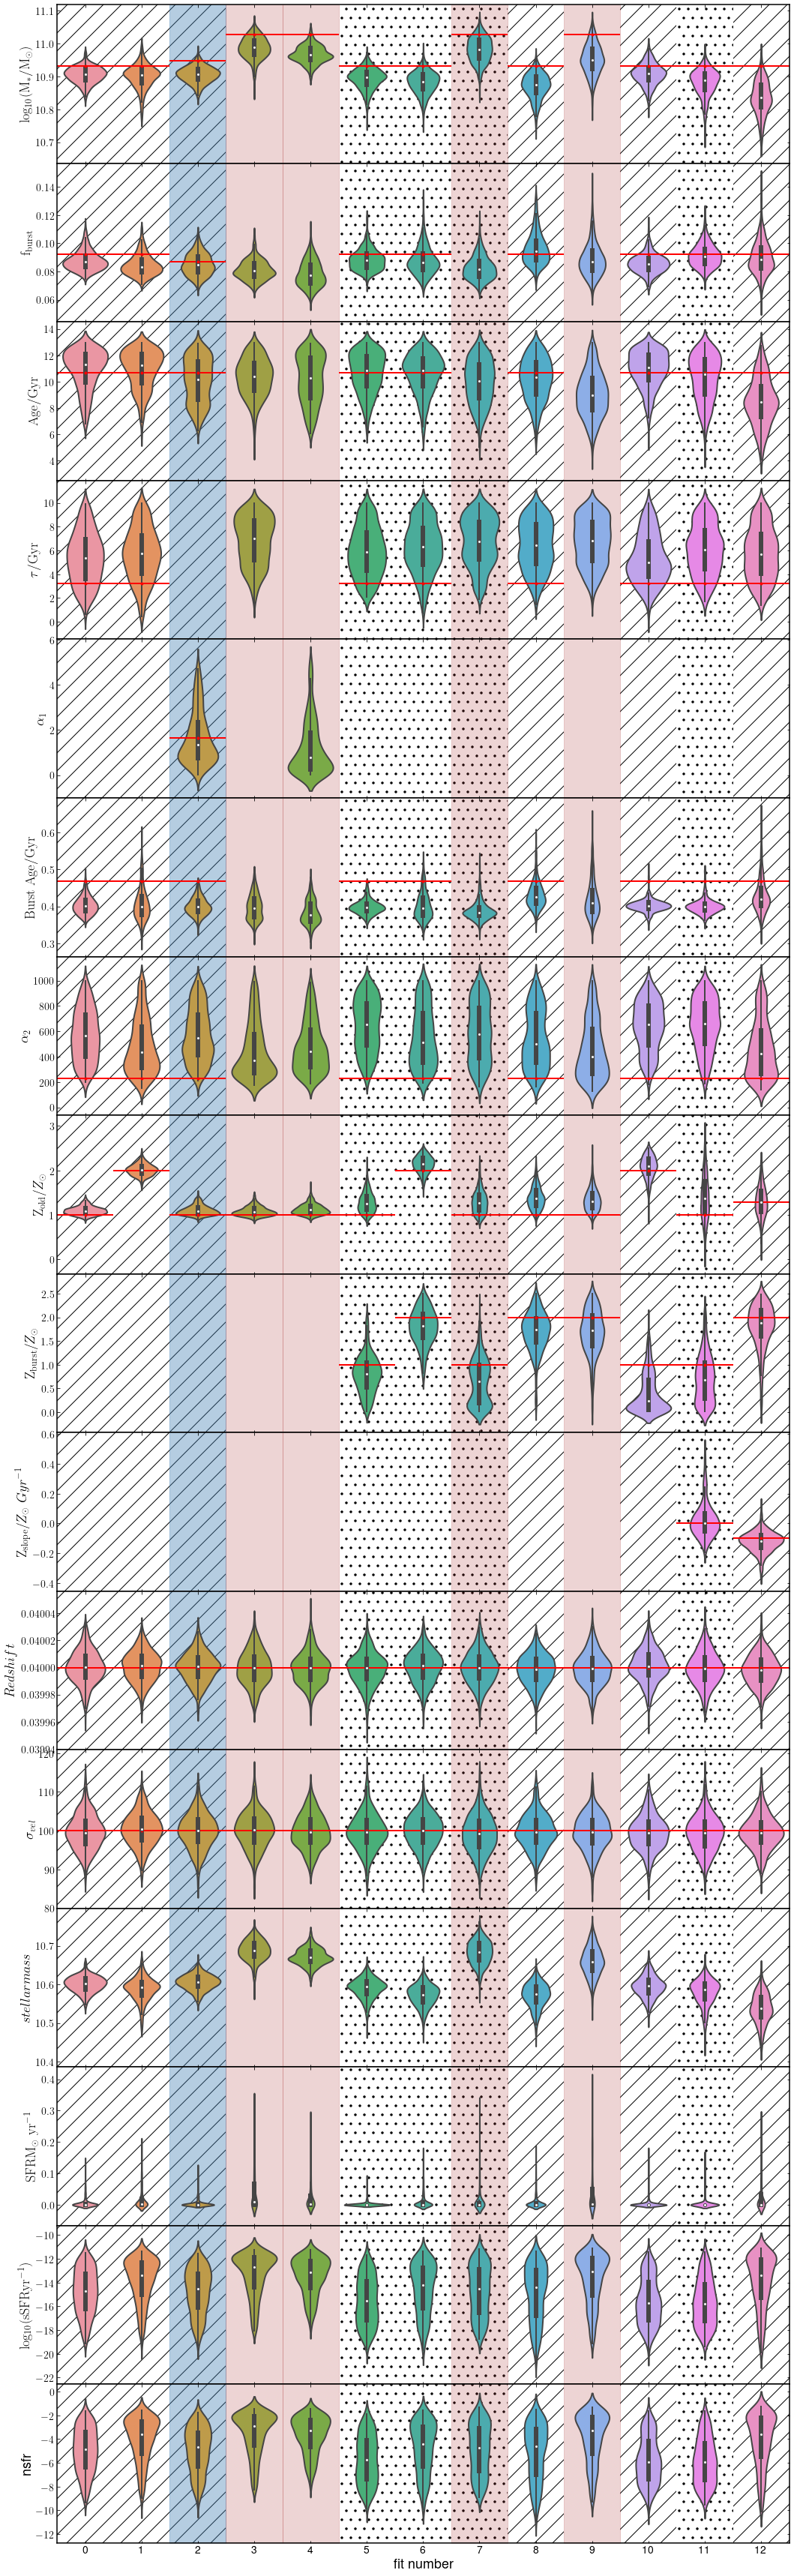

In [108]:
# age_list, age, tau, burstage, alpha, beta, fburst, Mstar
psb_wild2020_ind = {'age':popt_wild2020[0], 'tau':popt_wild2020[1], 'alpha1':np.nan, 
                    'burstage':popt_wild2020[2],
                    'alpha2':popt_wild2020[3], 'fburst':popt_wild2020[5], 'massformed':popt_wild2020[6]}
# age_list, age, alpha1, beta1, burstage, alpha2, beta2, fburst, Mstar
psb_twin_ind = {'age':popt_twin[0], 'tau':np.nan,
                'alpha1':popt_twin[1], 'burstage':popt_twin[3],
                'alpha2':popt_twin[4], 'fburst':popt_twin[6], 'massformed':popt_twin[7]}

ylabels = {
    "age": "\\mathrm{Age}/\\mathrm{Gyr}",
    "tau": "\\tau/\\mathrm{Gyr}",
    "alpha1": "\\alpha_1",
    "burstage": "\\mathrm{Burst\\ Age}/\\mathrm{Gyr}",
    "alpha2": "\\alpha_2",
    "fburst" : "\\mathrm{f_{burst}}",
    "massformed": "\\mathrm{log_{10}(M_*/M_{\\odot})}",
    "redshift": "Redshift",
    "veldisp": "\\sigma_{vel}",
    "stellar_mass": "stellar mass",
    "sfr": "\\mathrm{SFR}\\mathrm{M_\\odot\\ yr}^{-1}",
    "ssfr": "\\mathrm{log_{10}(sSFR\\mathrm{yr}^{-1})}",
    "metallicity_old": "\\mathrm{Z_{old}}/Z_{\\odot}",
    "metallicity_burst": "\\mathrm{Z_{burst}}/Z_{\\odot}",
    "metallicity_slope": "\\mathrm{Z_{slope}}/Z_{\\odot}\\ Gyr^{-1}"
          }

parameters = post_df.columns.drop(['galID', 'runID', 'fit_order'])
fig, ax = plt.subplots(len(parameters),1, figsize=[len(fit_table.index), 3*len(parameters)], sharex=True)
for i,col in enumerate(parameters):
    sns.violinplot(x='fit_order', y=col, data=post_df, ax=ax[i])
    # get truth values
    truth = [np.nan]*len(fit_table.index)
    
    # metallicity
    if col in ['metallicity_old', 'metallicity_burst', 'metallicity_slope']:
        truth = fit_table[f"m_zmet_{col.split('_')[-1]}"]
        for j,val in enumerate(truth):
            if val == 'auto':
                truth[j] = cosmo.age(0.04).value*abs(fit_table['m_zmet_slope'][j])
        for j in fit_table.index:
            if col == 'metallicity_old':
                if truth[j] == 'auto':
                    truth[j] = cosmo.age(0.04).value*abs(fit_table['m_zmet_slope'][j])
            elif col == 'metallicity_burst':
                if fit_table['m_CEH'][j] == 'delta' and fit_table['f_CEH'][j] in ['2step' ,'slope+2step']:
                    truth[j] = fit_table['m_zmet_old'][j]
            elif col == 'metallicity_slope':
                if fit_table['m_CEH'][j] in ['delta', '2step'] and fit_table['f_CEH'][j] == 'slope+2step':
                    truth[j] = 0
            
    elif col == 'veldisp':
        truth = fit_table['m_veldisp']
    elif col == 'redshift':
        truth = [0.04]*len(fit_table.index)
        
    # SFH properties
    elif col in ['age', 'burstage', 'alpha1', 'alpha2', 'fburst', 'massformed', 'tau']:
        truth = np.zeros(len(fit_table.index))
        for j in fit_table.index:
            if fit_table['m_SFH'][j] == 'psb_wild2020':
                truth[j] = psb_wild2020_ind[col]
            elif fit_table['m_SFH'][j] == 'psb_twin':
                truth[j] = psb_twin_ind[col]
            else:
                if col == 'massformed':
                    truth[j] = 11.027233041278691
                else:
                    truth[j] = np.nan
                
    ax[i].errorbar(np.arange(len(fit_table.index)), truth, xerr=0.5, ls='', marker='.', color='r')
    ax[i].set_xlabel('')
    if col in ylabels:
        ax[i].set_ylabel('$'+ylabels[col]+'$')
    else: ax[i].set_ylabel(col)
        
    ylims = ax[i].get_ylim()
    for j in fit_table.index:
        if fit_table['m_SFH'][j] == 'psb_wild2020':
            pass
        elif fit_table['m_SFH'][j] == 'psb_twin':
            ax[i].fill_between([j-0.5,j+0.5], [ylims[0]]*2, [ylims[1]]*2, color='steelblue', alpha=0.4,
                              zorder=-20)
        else:
            ax[i].fill_between([j-0.5,j+0.5], [ylims[0]]*2, [ylims[1]]*2, color='brown', alpha=0.2,
                              zorder=-20)
    
    for j in fit_table.index:
        if fit_table['m_SFH'][j] == fit_table['f_SFH'][j] and \
            fit_table['m_CEH'][j] == fit_table['f_CEH'][j] and \
            fit_table['m_dust'][j] == fit_table['f_dust'][j]:
            ax[i].fill_between([j-0.5,j+0.5], [ylims[0]]*2, [ylims[1]]*2, fc='white', alpha=0.5,
                              hatch='/', zorder=-21)
        if fit_table['m_CEH'][j] != fit_table['f_CEH'][j]:
            ax[i].fill_between([j-0.5,j+0.5], [ylims[0]]*2, [ylims[1]]*2, fc='white', alpha=0.5,
                              hatch=".", zorder=-21)
            
    ax[i].set_ylim(ylims)

ax[0].set_xlim([-0.5,len(fit_table.index)-0.5])
ax[-1].set_xlabel('fit number')
plt.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('metallicity model recovery tests2 violin.pdf')
plt.show()
#sns.violinplot(x='fit_order', y='massformed', data=post_df)
#plt.xlabel('fit')

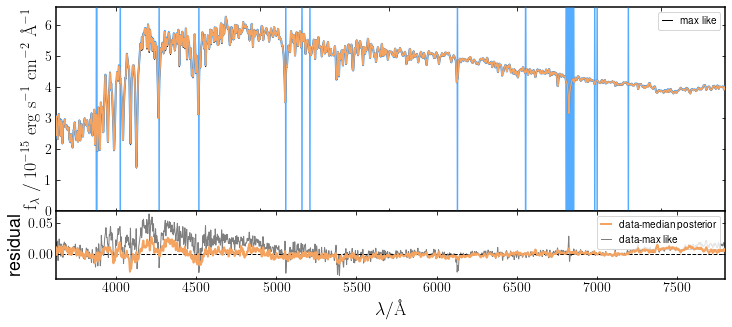

In [135]:
def plot_spec2(fit, ID, runID, save=True):

    # Make the figure
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 10,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    get_advanced_quantities(fit)

    naxes=1
    fig = plt.figure(figsize=(12, 5.*naxes))

    gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
    ax1 = plt.subplot(gs1[:3])
    ax3 = plt.subplot(gs1[3])

    mask = fit.galaxy.spectrum[:, 2] < 1.
    fit.galaxy.spectrum[mask, 2] = 0.

    y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1, label='data')
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)
    ind_bestfit = np.argmax(fit.results["lnlike"][fit.posterior.indices])
    bestfit_spec = fit.posterior.samples["spectrum"][ind_bestfit]
    ax1.plot(fit.galaxy.spectrum[:,0], bestfit_spec*10**-y_scale, color='k', lw=1, zorder=0,
             label='max like')

    post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #ax1.plot(fit.galaxy.spectrum[:,0],
    #         post_median*10**-y_scale,
    #         color="black", lw=1.0,zorder=11)

    ax3.axhline(0, color="black", ls="--", lw=1)
    ax3.plot(fit.galaxy.spectrum[:,0],(fit.galaxy.spectrum[:,1]-post_median)*10**-y_scale, 
             color="sandybrown", alpha=1.0, label='data-median posterior', zorder=10)
    ax3.plot(fit.galaxy.spectrum[:,0],(fit.galaxy.spectrum[:,1]-bestfit_spec)*10**-y_scale, 
             color="black", lw=1, alpha=0.5, label='data-max like')
    #ax1.set_xlim([3000,4200])
    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
    ax3.set_ylabel('residual')
    
    ax1.legend()
    ax3.legend(loc='upper right')
    plt.show()

plot_spec2(fit, ID, runID)

m_SFH                                                psb_wild2020
m_CEH                                                       delta
m_zmet_old                                                      1
m_zmet_burst                                                  NaN
m_zmet_slope                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       delta
f_CEH_fixed                                                 False
f_dust                                                       None
f_GPnoise                                                   False
f_nlive                                                       400
binby                                                           1
galID                                psb2_uniform1Zsun_veldisp100
runID     

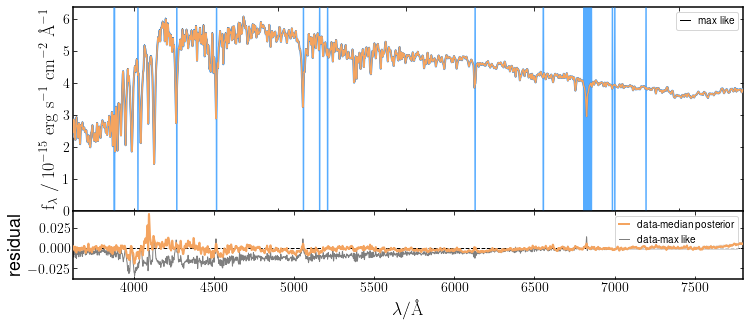

In [136]:
i = 0
row = fit_table.loc[i]
if row['old_fit']:
    # all old_fits are only using psb_twin for model creation
    psb_twin_popt = [1.26348321e+01, 8.70221355e-01, 9.64793965e+03, 5.53510051e-01, 
                     1.83730405e+02, 6.79456054e+02, 8.64240632e-02, 1.10272314e+01]
    psb_model = gen_model(row, vb=False, old_fit_params=psb_twin_popt)
else:
    psb_model = models[i]
fit_obj = fitting('../../..', psb_model, 
              0.04, row['binby'], sky_masking=False, full=True,
              model_galaxy_SNR=15)

ID = row['galID']
runID = row['runID']
print(row)
print('runID =', runID)

galaxy = pipes.galaxy(ID, fit_obj.load_manga_spec, photometry_exists=False)
pipes.config.Rspec = 4340
fit = pipes.fit(galaxy, {}, run=runID)

plot_spec2(fit, ID, runID)